In [102]:
# pip install CensusData

In [103]:
import pandas as pd
import censusdata
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [104]:
sharedFolder = '/work/group/egodat/reu23_clark/'
dataFolder = sharedFolder + 'data/'

In [105]:
statesShp = geopandas.read_file(dataFolder + "/cb_2018_us_state_500k.zip").to_crs(3857)
statesShp = statesShp[['GEOID', 'STUSPS', 'NAME', 'geometry']]

def plotUS():
    ax = statesShp.plot(figsize=(20, 10))
    ax.axis('equal')
    plt.xlim(-1.5e7, -0.7e7)
    plt.ylim(2.5e6, 7e6)
    return ax

In [106]:
xwalk = pd.read_pickle(dataFolder + "/xwalk_data_combined.pkl")
xwalk

ctyname          bgrp   cbsa
0        Rockingham County, NH  330150710012  14460
1         Merrimack County, NH  330130380002  18180
2         Merrimack County, NH  330130415001  18180
3      Hillsborough County, NH  330110225011  31700
4      Hillsborough County, NH  330110103022  31700
...                        ...           ...    ...
57404          Elko County, NV  320079515003  21220
57405          Elko County, NV  320079515003  21220
57406          Elko County, NV  320079517002  21220
57407          Elko County, NV  320079502001  21220
57408          Elko County, NV  320079507021  21220

[8126956 rows x 3 columns]

In [107]:
#Extract block group code
xwalk['fips'] = (xwalk['bgrp'] / 10**7).astype(int)
fipsToCbsa = xwalk.groupby('fips').first()['cbsa']
fipsToCbsa = dict(zip(fipsToCbsa.index, fipsToCbsa.values)) #Dict is faster for lookup

In [108]:
# https://api.census.gov/data/2021/acs/acs5/variables.html

# variable_code: (readable_name, earliest_year, aggrigation_type)
demographic_variables_dict = {
    'B01003_001E': ('Total_Population', 2000, 'sum'),
    'B01001_002E': ('Total_Male_Pop', 2000, 'sum'),
    'B01001_026E': ('Total_Female_Pop', 2000, 'sum'),
    'B01002_001E': ('Median_Age', 2000, 'mean'),
    'B01002_002E': ('M_Median_Age', 2000, 'mean'),
    'B01002_003E': ('F_Median_Age', 2000, 'mean'),
    'B02001_002E': ('Race_white', 2000, 'sum'),
    'B02001_003E': ('Race_black', 2000, 'sum'),
    'B02001_004E': ('Race_Am_Indian', 2000, 'sum'),
    'B02001_005E': ('Race_Asian', 2000, 'sum'),
    'B02001_006E': ('Race_Pac_Isl', 2000, 'sum'),
    'B20004_001E': ('Median_Income', 2000, 'mean'),
    'B20004_002E': ('Less_High', 2000, 'sum'),
    'B20004_003E': ('High_Equiv', 2000, 'sum'),
    'B20004_004E': ('College_Assoc_Equiv', 2000, 'sum'),
    'B20004_005E': ('Bachelors', 2000, 'sum'),
    'B20004_006E': ('Grad_Prof', 2000, 'sum'),
    
    #Housing Variables
    'B25077_001E': ('Med_House_Val', 2000, 'mean'),
    #Median Earnings by Occupation
    'B24031_002E': ('Ag_For_Fish_Hunt_Mine', 2000, 'mean'),
    #'B24031_003E':'Ag_For_Fish_Hunt'
    #'B24031_004E':'Mine_Fish'
    'B24031_005E': ('Construction', 2000, 'mean'),
    'B24031_006E': ('Manufacturing', 2000, 'mean'),
    'B24031_007E': ('Wholesale', 2000, 'mean'),
    'B24031_008E': ('Retail', 2000, 'mean'),
    'B24031_009E': ('Trans_Ware_Util', 2000, 'mean'),
    #'B24031_010E':'Trans_Ware'
    #'B24031_011E':'Util'
    'B24031_012E': ('Information', 2000, 'mean'),
    'B24031_013E': ('Fin_Insur_Real', 2000, 'mean'),
    'B24031_014E': ('Fin_Insur', 2000, 'mean'),
    'B24031_015E': ('Real_Rental', 2000, 'mean'),
    #'B24031_016E':'Prof_Sci_Mngmt'
    'B24031_017E': ('Prof_Sci_Tech', 2000, 'mean'),
    'B24031_018E': ('Mngmt_Enter', 2000, 'mean'),
    'B24031_019E': ('Admin_WstMngmt', 2000, 'mean'),
    #'B24031_020E':'Ed_Health_Social'
    'B24031_021E': ('Ed_Servc', 2000, 'mean'),
    'B24031_022E': ('Hlthcr_Social', 2000, 'mean'),
    #'B24031_023E':'Arts_Entr_Rec_Fod'
    'B24031_024E': ('Arts_Entr_Rec', 2000, 'mean'),
    'B24031_025E': ('Accom_Food_Srvc', 2000, 'mean'),
    'B24031_026E': ('Other_Servc', 2000, 'mean'),
    'B24031_027E': ('Public_admin', 2000, 'mean'),
    
    
    #Civilians by Detailed Occupation
    'B24114_001E': ('Num_Total_Worker', 2018, 'sum'),
    'B24114_064E': ('Num_Comp_Info_Res', 2018, 'sum'),
    'B24114_068E': ('Num_Soft_Dev', 2018, 'sum'),
    'B24114_065E': ('Num_Comp_Sys_Analyst', 2018, 'sum'),
    'B24114_066E': ('Num_Info_Sec_Analyst', 2018, 'sum'),
    'B24114_067E': ('Num_Comp_Programmer', 2018, 'sum'),
    'B24114_069E': ('Num_Soft_Qual', 2018, 'sum'),
    'B24114_070E': ('Num_Web_Dev', 2018, 'sum'),
    
    
    #OCCUPATION BY MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) FOR THE FULL-TIME, YEAR-ROUND CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER
    'B24021_001E': ('Sal_Avg_Occ', 2000, 'mean'),
    'B24021_006E': ('Avg_Comp_EngSci', 2000, 'mean'),
    'B24012_003E': ('Avg_Mngmt_Bus_Fin', 2000, 'mean'),
    
    #Geographic Mobility Stuff
    'B07009_005E': ('G_Mobil_Bach', 2000, 'sum'),
    'B07009_006E': ('G_Mobil_Prof', 2000, 'sum')
}

# B20004_001E is for median income by educational attainment

years = range(2009, 2021+1, 1)
dfs = []

for year in years:
    df = censusdata.download(
        'acs5',
        year,
        censusdata.censusgeo([('county', '*')]),
        [k for k, (n, y, a) in demographic_variables_dict.items() if y <= year] #Skip if not available for year
    )
    df['year'] = year
    dfs.append(df)

data = pd.concat(dfs)
data

B01003_001E  B01001_002E  \
Aleutians East Borough, Alaska: Summary level: ...         2959         1965   
Aleutians West Census Area, Alaska: Summary lev...         5505         4124   
Anchorage Municipality, Alaska: Summary level: ...       280389       143053   
Bethel Census Area, Alaska: Summary level: 050,...        17151         9012   
Bristol Bay Borough, Alaska: Summary level: 050...          682          328   
...                                                         ...          ...   
Vega Baja Municipio, Puerto Rico: Summary level...        54544        26057   
Vieques Municipio, Puerto Rico: Summary level: ...         8317         4239   
Villalba Municipio, Puerto Rico: Summary level:...        22341        10796   
Yabucoa Municipio, Puerto Rico: Summary level: ...        31047        15000   
Yauco Municipio, Puerto Rico: Summary level: 05...        34704        16548   

                                                    B01001_026E  B01002_001E  \
Aleutians East Borough, Alaska: Summary level: ...          994         37.2   
Aleutians West Census Area, Alaska: Summary lev...         1381         40.8   
Anchorage Municipality, Alaska: Summary level: ...       137336         32.2   
Bethel Census Area, Alaska: Summary level: 050,...         8139         26.2   
Bristol Bay Borough, Alaska: Summary level: 050...          354         36.0   
...                                                         ...          ...   
Vega Baja Municipio, Puerto Rico: Summary level...        28487         43.1   
Vieques Municipio, Puerto Rico: Summary level: ...         4078         43.6   
Villalba Municipio, Puerto Rico: Summary level:...        11545         42.0   
Yabucoa Municipio, Puerto Rico: Summary level: ...        16047         44.9   
Yauco Municipio, Puerto Rico: Summary level: 05...        18156         45.5   

                                                    B01002_002E  B01002_003E  \
Aleutians East Borough, Alaska: Summary level: ...         37.3         36.9   
Aleutians West Census Area, Alaska: Summary lev...         41.0         40.0   
Anchorage Municipality, Alaska: Summary level: ...         31.0         33.1   
Bethel Census Area, Alaska: Summary level: 050,...         26.2         26.1   
Bristol Bay Borough, Alaska: Summary level: 050...         32.0         39.6   
...                                                         ...          ...   
Vega Baja Municipio, Puerto Rico: Summary level...         41.5         44.6   
Vieques Municipio, Puerto Rico: Summary level: ...         40.9         45.9   
Villalba Municipio, Puerto Rico: Summary level:...         40.7         42.9   
Yabucoa Municipio, Puerto Rico: Summary level: ...         43.7         46.0   
Yauco Municipio, Puerto Rico: Summary level: 05...         43.7         47.6   

                                                    B02001_002E  B02001_003E  \
Aleutians East Borough, Alaska: Summary level: ...          412          298   
Aleutians West Census Area, Alaska: Summary lev...         2127          565   
Anchorage Municipality, Alaska: Summary level: ...       195537        16531   
Bethel Census Area, Alaska: Summary level: 050,...         2116           32   
Bristol Bay Borough, Alaska: Summary level: 050...          370            0   
...                                                         ...          ...   
Vega Baja Municipio, Puerto Rico: Summary level...        30690         2409   
Vieques Municipio, Puerto Rico: Summary level: ...         2592          629   
Villalba Municipio, Puerto Rico: Summary level:...        10502         1784   
Yabucoa Municipio, Puerto Rico: Summary level: ...         3190        16119   
Yauco Municipio, Puerto Rico: Summary level: 05...        24533         1282   

                                                    B02001_004E  B02001_005E  \
Aleutians East Borough, Alaska: Summary level: ...          534         1405   
Aleutians West Census Area, Alaska: Summary lev.

In [109]:
# to rename variable, add to dict
data.fillna(value=np.nan, inplace=True)
data.rename(columns={k: n for k, (n, y, a) in demographic_variables_dict.items()},
            inplace=True)
data = data.reset_index().rename(columns = {"index":"FIPS"})
data["FIPS"] = data["FIPS"].apply(lambda x: x.params()[0][1] + x.params()[1][1])
data['FIPS'] = data['FIPS'].astype(int)
data[data < 0] = np.nan
data

FIPS  Total_Population  Total_Male_Pop  Total_Female_Pop  Median_Age  \
0       2013              2959            1965               994        37.2   
1       2016              5505            4124              1381        40.8   
2       2020            280389          143053            137336        32.2   
3       2050             17151            9012              8139        26.2   
4       2060               682             328               354        36.0   
...      ...               ...             ...               ...         ...   
41862  72145             54544           26057             28487        43.1   
41863  72147              8317            4239              4078        43.6   
41864  72149             22341           10796             11545        42.0   
41865  72151             31047           15000             16047        44.9   
41866  72153             34704           16548             18156        45.5   

       M_Median_Age  F_Median_Age  Race_white  Race_black  Race_Am_Indian  \
0              37.3          36.9         412         298             534   
1              41.0          40.0        2127         565             401   
2              31.0          33.1      195537       16531           15796   
3              26.2          26.1        2116          32           13795   
4              32.0          39.6         370           0             170   
...             ...           ...         ...         ...             ...   
41862          41.5          44.6       30690        2409              50   
41863          40.9          45.9        2592         629               0   
41864          40.7          42.9       10502        1784               0   
41865          43.7          46.0        3190       16119               0   
41866          43.7          47.6       24533        1282              48   

       ...  G_Mobil_Prof  year  Num_Total_Worker  Num_Comp_Info_Res  \
0      ...          35.0  2009               NaN                NaN   
1      ...          66.0  2009               NaN                NaN   
2      ...       19785.0  2009               NaN                NaN   
3      ...         455.0  2009               NaN                NaN   
4      ...           9.0  2009               NaN                NaN   
...    ...           ...   ...               ...                ...   
41862  ...           NaN  2021               NaN                NaN   
41863  ...           NaN  2021               NaN                NaN   
41864  ...           NaN  2021               NaN                NaN   
41865  ...           NaN  2021               NaN                NaN   
41866  ...           NaN  2021               NaN                NaN   

       Num_Soft_Dev  Num_Comp_Sys_Analyst  Num_Info_Sec_Analyst  \
0               NaN                   NaN                   NaN   
1               NaN                   NaN                   NaN   
2               NaN                   NaN                   NaN   
3               NaN                   NaN                   NaN   
4               NaN                   NaN                   NaN   
...             ...                   ...                   ...   
41862           NaN                   NaN                   NaN   
41863           NaN                   NaN                   NaN   
41864           NaN                   NaN                   NaN   
41865           NaN                   NaN                   NaN   
41866           NaN                   NaN                   NaN   

       Num_Comp_Programmer  Num_Soft_Qual  Num_Web_Dev  
0                      NaN            NaN          NaN  
1                      NaN            NaN          NaN  
2                      NaN            NaN          NaN  
3                      NaN            NaN          NaN  
4                      NaN            NaN          NaN  
...                    ...            ...          ...  
41862                  NaN            NaN          NaN  
41863   

In [110]:
data['CBSA'] = data['FIPS'].apply(lambda c: fipsToCbsa.get(c, 99999))
data

FIPS  Total_Population  Total_Male_Pop  Total_Female_Pop  Median_Age  \
0       2013              2959            1965               994        37.2   
1       2016              5505            4124              1381        40.8   
2       2020            280389          143053            137336        32.2   
3       2050             17151            9012              8139        26.2   
4       2060               682             328               354        36.0   
...      ...               ...             ...               ...         ...   
41862  72145             54544           26057             28487        43.1   
41863  72147              8317            4239              4078        43.6   
41864  72149             22341           10796             11545        42.0   
41865  72151             31047           15000             16047        44.9   
41866  72153             34704           16548             18156        45.5   

       M_Median_Age  F_Median_Age  Race_white  Race_black  Race_Am_Indian  \
0              37.3          36.9         412         298             534   
1              41.0          40.0        2127         565             401   
2              31.0          33.1      195537       16531           15796   
3              26.2          26.1        2116          32           13795   
4              32.0          39.6         370           0             170   
...             ...           ...         ...         ...             ...   
41862          41.5          44.6       30690        2409              50   
41863          40.9          45.9        2592         629               0   
41864          40.7          42.9       10502        1784               0   
41865          43.7          46.0        3190       16119               0   
41866          43.7          47.6       24533        1282              48   

       ...  year  Num_Total_Worker  Num_Comp_Info_Res  Num_Soft_Dev  \
0      ...  2009               NaN                NaN           NaN   
1      ...  2009               NaN                NaN           NaN   
2      ...  2009               NaN                NaN           NaN   
3      ...  2009               NaN                NaN           NaN   
4      ...  2009               NaN                NaN           NaN   
...    ...   ...               ...                ...           ...   
41862  ...  2021               NaN                NaN           NaN   
41863  ...  2021               NaN                NaN           NaN   
41864  ...  2021               NaN                NaN           NaN   
41865  ...  2021               NaN                NaN           NaN   
41866  ...  2021               NaN                NaN           NaN   

       Num_Comp_Sys_Analyst  Num_Info_Sec_Analyst  Num_Comp_Programmer  \
0                       NaN                   NaN                  NaN   
1                       NaN                   NaN                  NaN   
2                       NaN                   NaN                  NaN   
3                       NaN                   NaN                  NaN   
4                       NaN                   NaN                  NaN   
...                     ...                   ...                  ...   
41862                   NaN                   NaN                  NaN   
41863                   NaN                   NaN                  NaN   
41864                   NaN                   NaN                  NaN   
41865                   NaN                   NaN                  NaN   
41866                   NaN                   NaN                  NaN   

       Num_Soft_Qual  Num_Web_Dev   CBSA  
0                NaN          NaN  99999  
1                NaN          NaN  99999  
2                NaN          NaN  11260  
3                NaN          NaN  99999  
4                NaN          NaN  99999  
...              ...          ...    ...  
41862            NaN          NaN  99999  
41863            NaN          NaN  9

In [111]:
aggType = {n: a for k, (n, y, a) in demographic_variables_dict.items()}
dataByCbsa = data.groupby(by=['CBSA', 'year']).agg(aggType).reset_index()

In [112]:
dataByCbsa['Education_Pop'] = dataByCbsa['Less_High'] + dataByCbsa['High_Equiv'] + dataByCbsa['College_Assoc_Equiv'] + dataByCbsa['Bachelors'] + dataByCbsa['Grad_Prof']
dataByCbsa['Less_High_pct'] = dataByCbsa['Less_High'] / dataByCbsa['Education_Pop']
dataByCbsa['High_Equiv_pct'] = dataByCbsa['High_Equiv'] / dataByCbsa['Education_Pop']
dataByCbsa['College_Assoc_Equiv_pct'] = dataByCbsa['College_Assoc_Equiv'] / dataByCbsa['Education_Pop']
dataByCbsa['Bachelors_pct'] = dataByCbsa['Bachelors'] / dataByCbsa['Education_Pop']
dataByCbsa['Grad_Prof_pct'] = dataByCbsa['Grad_Prof'] / dataByCbsa['Education_Pop']

dataByCbsa['Bach_and_Above_pct'] = (dataByCbsa['Bachelors'] + dataByCbsa['Grad_Prof']) / dataByCbsa['Education_Pop']

dataByCbsa['Computer_Total'] = dataByCbsa['Num_Total_Worker'] + dataByCbsa['Num_Comp_Info_Res'] + dataByCbsa['Num_Soft_Dev'] + dataByCbsa['Num_Comp_Sys_Analyst'] + dataByCbsa['Num_Info_Sec_Analyst'] + dataByCbsa['Num_Comp_Programmer'] + dataByCbsa['Num_Soft_Qual'] + dataByCbsa['Num_Web_Dev']


dataByCbsa['G_Mobil_Bach_Prof'] = dataByCbsa['G_Mobil_Bach'] + dataByCbsa['G_Mobil_Prof'] 

In [113]:
dataByCbsa

CBSA  year  Total_Population  Total_Male_Pop  Total_Female_Pop  \
0      10100  2009             38997           19038             19959   
1      10100  2010             40058           19558             20500   
2      10100  2011             40315           19782             20533   
3      10100  2012             40612           20001             20611   
4      10100  2013             41033           20159             20874   
...      ...   ...               ...             ...               ...   
12059  99999  2017          22372520        11150761          11221759   
12060  99999  2018          22272518        11099521          11172997   
12061  99999  2019          22178554        11052803          11125751   
12062  99999  2020          22103803        11015701          11088102   
12063  99999  2021          22003258        11013539          10989719   

       Median_Age  M_Median_Age  F_Median_Age  Race_white  Race_black  ...  \
0       42.050000     40.450000     43.250000       37087          23  ...   
1       42.900000     41.650000     44.200000       37805         159  ...   
2       42.900000     41.550000     43.900000       38036         248  ...   
3       42.650000     41.150000     43.700000       38214         286  ...   
4       42.950000     40.750000     44.500000       38428         396  ...   
...           ...           ...           ...         ...         ...  ...   
12059   43.116812     41.836739     44.505797    18146065     2173702  ...   
12060   43.271522     41.953478     44.660942    18001192     2194587  ...   
12061   43.427246     42.142174     44.830580    17868699     2205230  ...   
12062   43.565243     42.268863     44.940912    17478046     2163319  ...   
12063   43.435844     42.310355     44.682839    16930541     2064335  ...   

       G_Mobil_Prof  Education_Pop  Less_High_pct  High_Equiv_pct  \
0            1373.0       303538.0       0.119293        0.159697   
1            1394.0       318079.0       0.105005        0.161372   
2            1601.0       324925.0       0.123705        0.162136   
3            1742.0       333678.0       0.143414        0.158584   
4            1957.0       340742.0       0.136552        0.161568   
...             ...            ...            ...             ...   
12059      904558.0    228304207.0       0.123651        0.163611   
12060      926514.0    234733435.0       0.124274        0.164304   
12061      951808.0    240615087.0       0.126011        0.165254   
12062      990617.0    245357846.0       0.125985        0.166843   
12063     1003290.0    257325713.0       0.126880        0.166371   

       College_Assoc_Equiv_pct  Bachelors_pct  Grad_Prof_pct  \
0                     0.208863       0.222806       0.289341   
1                     0.189387       0.221712       0.322524   
2                     0.189493       0.230696       0.293969   
3                     0.192128       0.231816       0.274058   
4                     0.193930       0.231950       0.276001   
...                        ...            ...            ...   
12059                 0.182954       0.238989       0.290794   
12060                 0.183187       0.239112       0.289124   
12061                 0.183618       0.238212       0.286905   
12062                 0.185187       0.237769       0.284216   
12063                 0.183848       0.238252       0.284648   

       Bach_and_Above_pct  Computer_Total  G_Mobil_Bach_Prof  
0                0.512147             0.0             6201.0  
1                0.544236             0.0             6343.0  
2                0.524666             0.0             6667.0  
3                0.505874             0.0             7016.0  
4                0.507950             0.0             7228.0  
...                   ...             ...                ...  
12059            0.529783             0.0          2456566.0  
12060            0.528235             0.0          2508884.0  
12061            

In [114]:
dataByCbsa.to_pickle(sharedFolder + 'ACS_data.pkl')

# Analysis

In [115]:
gdf = pd.read_pickle(sharedFolder + 'gdf.pkl')
gdf

CBSA                           LSAD  POPESTIMATE2020  POPESTIMATE2021  \
0    10180  Metropolitan Statistical Area           176866           177829   
1    10420  Metropolitan Statistical Area           701625           696225   
2    10500  Metropolitan Statistical Area           148244           144922   
3    10540  Metropolitan Statistical Area           128978           129948   
4    10580  Metropolitan Statistical Area           899748           905369   
..     ...                            ...              ...              ...   
921  49300  Micropolitan Statistical Area           116906           116129   
922  49380  Micropolitan Statistical Area            22207            22047   
923  49460  Micropolitan Statistical Area            23282            23334   
924  49780  Micropolitan Statistical Area            86450            86574   
925  49820  Micropolitan Statistical Area            13874            13893   

     POPESTIMATE2022                         NAME  \
0             179308                  Abilene, TX   
1             697627                    Akron, OH   
2             145786                   Albany, GA   
3             130467           Albany-Lebanon, OR   
4             904617  Albany-Schenectady-Troy, NY   
..               ...                          ...   
921           116559                  Wooster, OH   
922            21947              Worthington, MN   
923            23373                  Yankton, SD   
924            86113               Zanesville, OH   
925            13849                   Zapata, TX   

                                              geometry  metro  micro  \
0    POLYGON ((-11148262.500 3832132.455, -11148249...  False  False   
1    POLYGON ((-9060481.928 5063847.837, -9060475.5...  False  False   
2    POLYGON ((-9400975.184 3713776.408, -9400980.6...  False  False   
3    POLYGON ((-13720236.776 5551262.937, -13720393...  False  False   
4    POLYGON ((-8247992.807 5305256.748, -8248085.6...  False  False   
..                                                 ...    ...    ...   
921  POLYGON ((-9089178.853 5010653.858, -9088979.1...  False  False   
922  POLYGON ((-10627927.538 5441934.306, -10627791...  False   True   
923  POLYGON ((-10855702.126 5337734.746, -10853435...  False   True   
924  POLYGON ((-9149881.580 4868949.855, -9149879.9...  False   True   
925  POLYGON ((-11063533.373 3121145.410, -11063672...  False   True   

                                                  buff  inBuff  \
0    POLYGON ((-11309677.340 3783320.344, -11309649...    True   
1    POLYGON ((-9254365.317 5020257.954, -9254364.7...    True   
2    POLYGON ((-9578772.815 3741602.731, -9578761.8...    True   
3    POLYGON ((-13880404.968 5518947.795, -13880524...    True   
4    POLYGON ((-8472736.168 5278351.957, -8472566.1...    True   
..                                                 ...     ...   
921  POLYGON ((-9303427.427 5003041.204, -9303435.5...    True   
922  POLYGON ((-10853572.863 5404615.190, -10853573...   False   
923  POLYGON ((-11029881.460 5334892.015, -11029883...   False   
924  POLYGON ((-9314594.513 4866712.033, -9313763.6...    True   
925  POLYGON ((-11231367.159 3143424.471, -11231876...   False   

     commuteBuffCount_19  workingPop_19  commutePercent_19  \
0                 7720.0        69422.0          11.120394   
1                90313.0       323548.0          27.913324   
2                 4136.0        53083.0           7.791572   
3                 6558.0        55731.0          11.767239   
4                25671.0       418341.0           6.136382   
..                   ...            ...                ...   
921               8894.0        50856.0          17.488595   
922                  0.0        10260.0           0.000000   
923                  0.0        10934.0           0.000000   
924               9978.0        34969.0          28.533844   
925                  0.0         4118.0           0.000000   

     commuteBuffC

In [116]:
merge = pd.merge(gdf, dataByCbsa, on='CBSA', how='inner')
byYear = merge.groupby(by=['year', 'CBSA']).first()
byYear

LSAD  POPESTIMATE2020  POPESTIMATE2021  \
year CBSA                                                                     
2009 10100  Micropolitan Statistical Area            42204            42118   
     10140  Micropolitan Statistical Area            75855            76787   
     10180  Metropolitan Statistical Area           176866           177829   
     10220  Micropolitan Statistical Area            38087            38195   
     10300  Micropolitan Statistical Area            99320            99202   
...                                   ...              ...              ...   
2021 49660  Metropolitan Statistical Area           540211           537837   
     49700  Metropolitan Statistical Area           181458           182254   
     49740  Metropolitan Statistical Area           204528           206241   
     49780  Micropolitan Statistical Area            86450            86574   
     49820  Micropolitan Statistical Area            13874            13893   

            POPESTIMATE2022                               NAME  \
year CBSA                                                        
2009 10100            42037                       Aberdeen, SD   
     10140            77038                       Aberdeen, WA   
     10180           179308                        Abilene, TX   
     10220            38141                            Ada, OK   
     10300            98567                         Adrian, MI   
...                     ...                                ...   
2021 49660           535499  Youngstown-Warren-Boardman, OH-PA   
     49700           182813                      Yuba City, CA   
     49740           207842                           Yuma, AZ   
     49780            86113                     Zanesville, OH   
     49820            13849                         Zapata, TX   

                                                     geometry  metro  micro  \
year CBSA                                                                     
2009 10100  POLYGON ((-10989736.448 5659978.604, -10990063...  False   True   
     10140  POLYGON ((-13837615.681 5982098.516, -13837721...  False   True   
     10180  POLYGON ((-11148262.500 3832132.455, -11148249...  False  False   
     10220  POLYGON ((-10790478.575 4120536.368, -10790479...  False   True   
     10300  POLYGON ((-9391131.716 5145826.837, -9391131.7...  False   True   
...                                                       ...    ...    ...   
2021 49660  POLYGON ((-9017133.666 5032154.477, -9017136.6...  False  False   
     49700  POLYGON ((-13539095.212 4764106.072, -13539054...  False  False   
     49740  POLYGON ((-12775445.758 3848066.261, -12775405...  False  False   
     49780  POLYGON ((-9149881.580 4868949.855, -9149879.9...  False   True   
     49820  POLYGON ((-11063533.373 3121145.410, -11063672...  False   True   

                                                         buff  inBuff  ...  \
year CBSA                                                              ...   
2009 10100  POLYGON ((-11260422.376 5673350.686, -11260422...   False  ...   
     10140  POLYGON ((-14011312.614 6012982.039, -14012149...    True  ...   
     10180  POLYGON ((-11309677.340 3783320.344, -11309649...    True  ...   
     10220  POLYGON ((-10951414.331 4125460.111, -10951415...    True  ...   
     10300  POLYGON ((-9552071.161 5147203.615, -9552071.5...    True  ...   
...                                                       ...     ...  ...   
2021 49660  POLYGON ((-9187449.917 5005143.524, -9187448.1...    True  ...   
     49700  POLYGON ((-13735793.573 4749232.461, -13736149...    True  ...   
     49740  POLYGON ((-12941846.948 3839265.947, -12941917...    True  ...   
     49780  POLYGON ((-9314594.513 4866712.033, -9313763.6...    True  ...   
     49820  POLYGON ((-11231367.159 3143424.471, -11231876...   False  ...   

            G_Mobil_Prof  Education_Pop  Less_High_pct  High_Equiv_pct  \
year CBSA                        

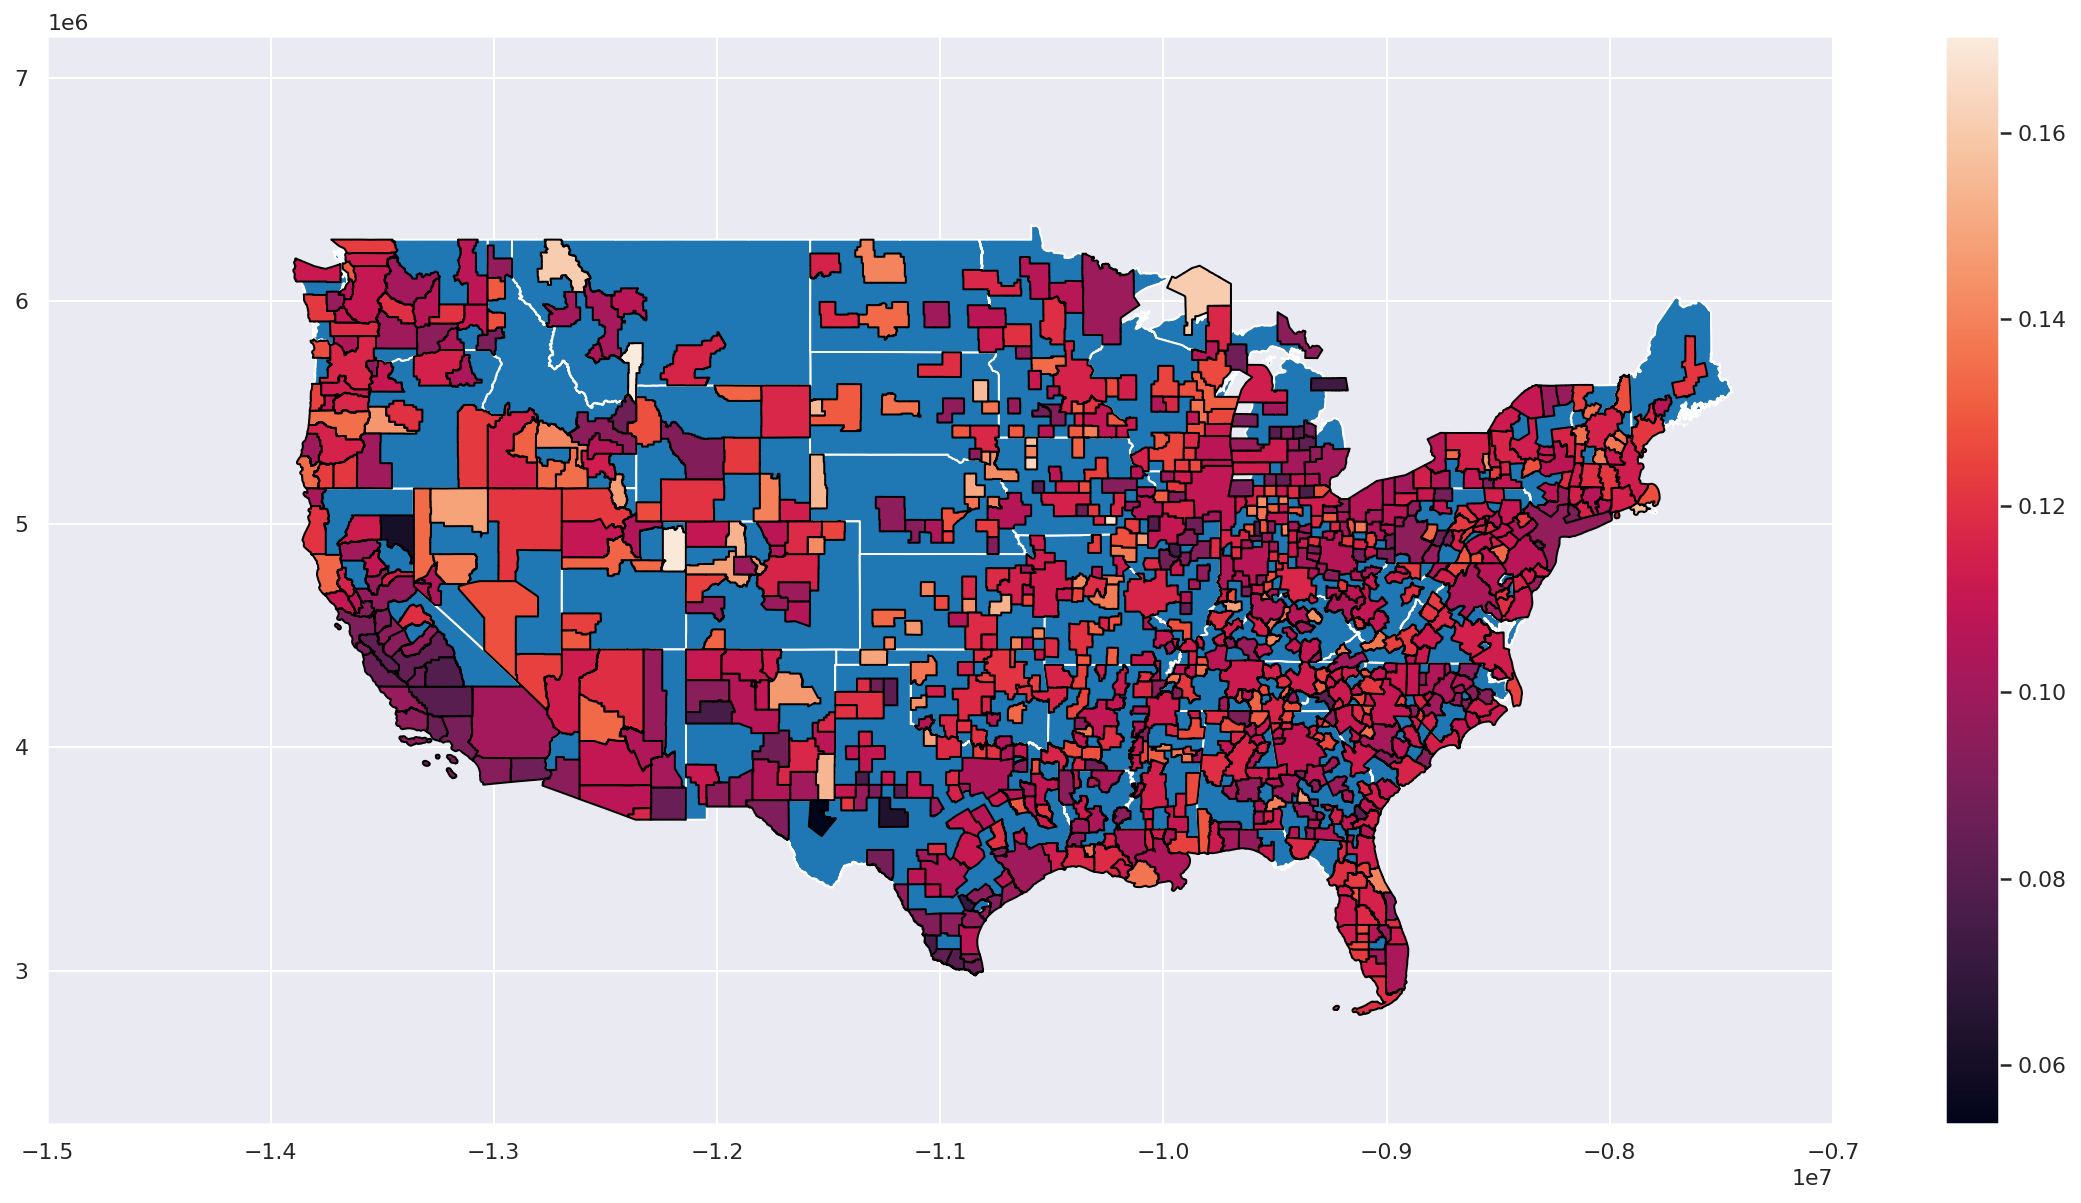

In [117]:
ax = plotUS()
byYear.loc[2009].plot(ax=ax, column='Less_High_pct', edgecolor="black", linewidth=1, legend=True);

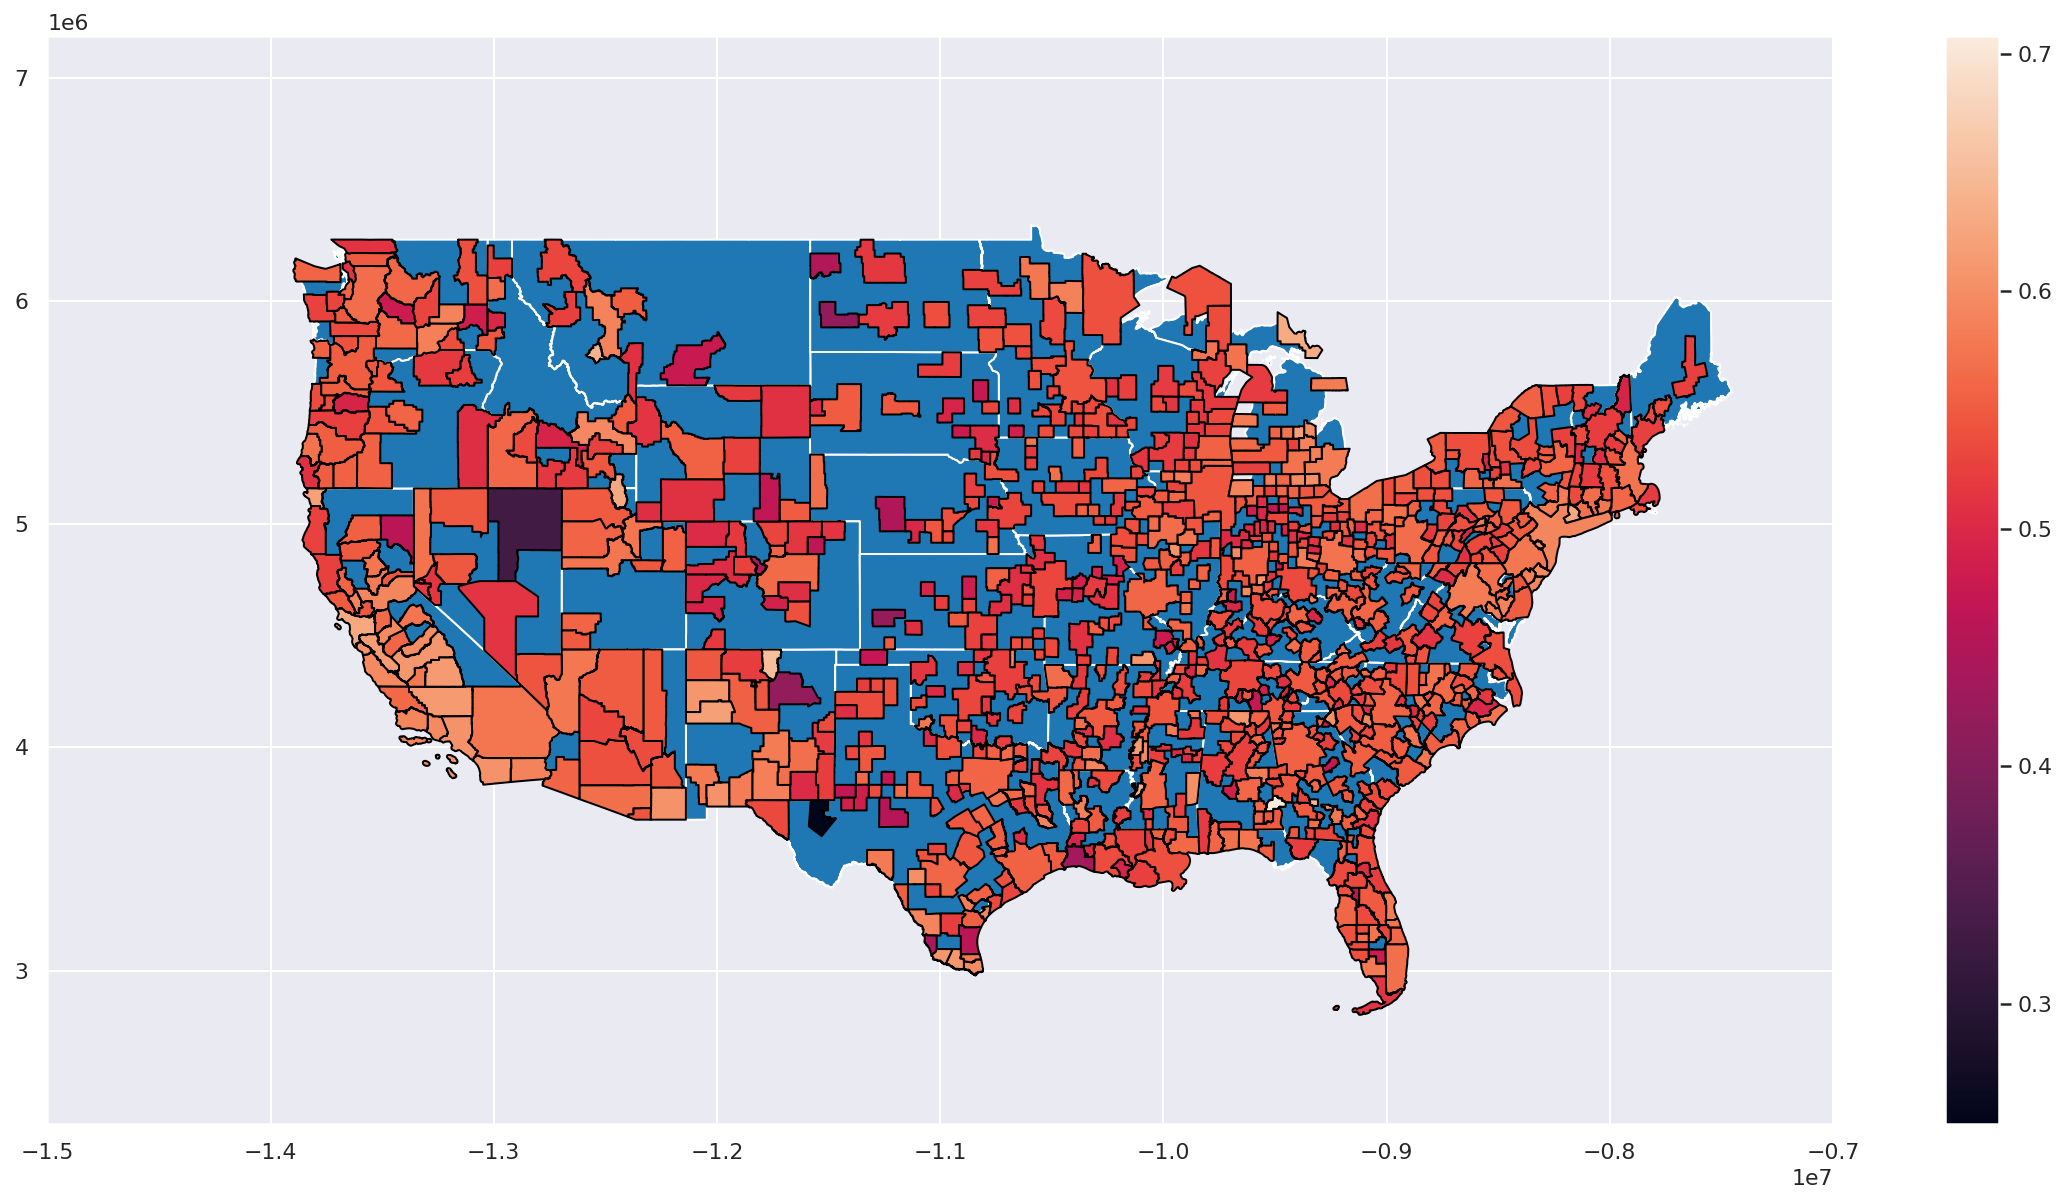

In [118]:
ax = plotUS()
byYear.loc[2020].plot(ax=ax, column='Bach_and_Above_pct', edgecolor="black", linewidth=1, legend=True);

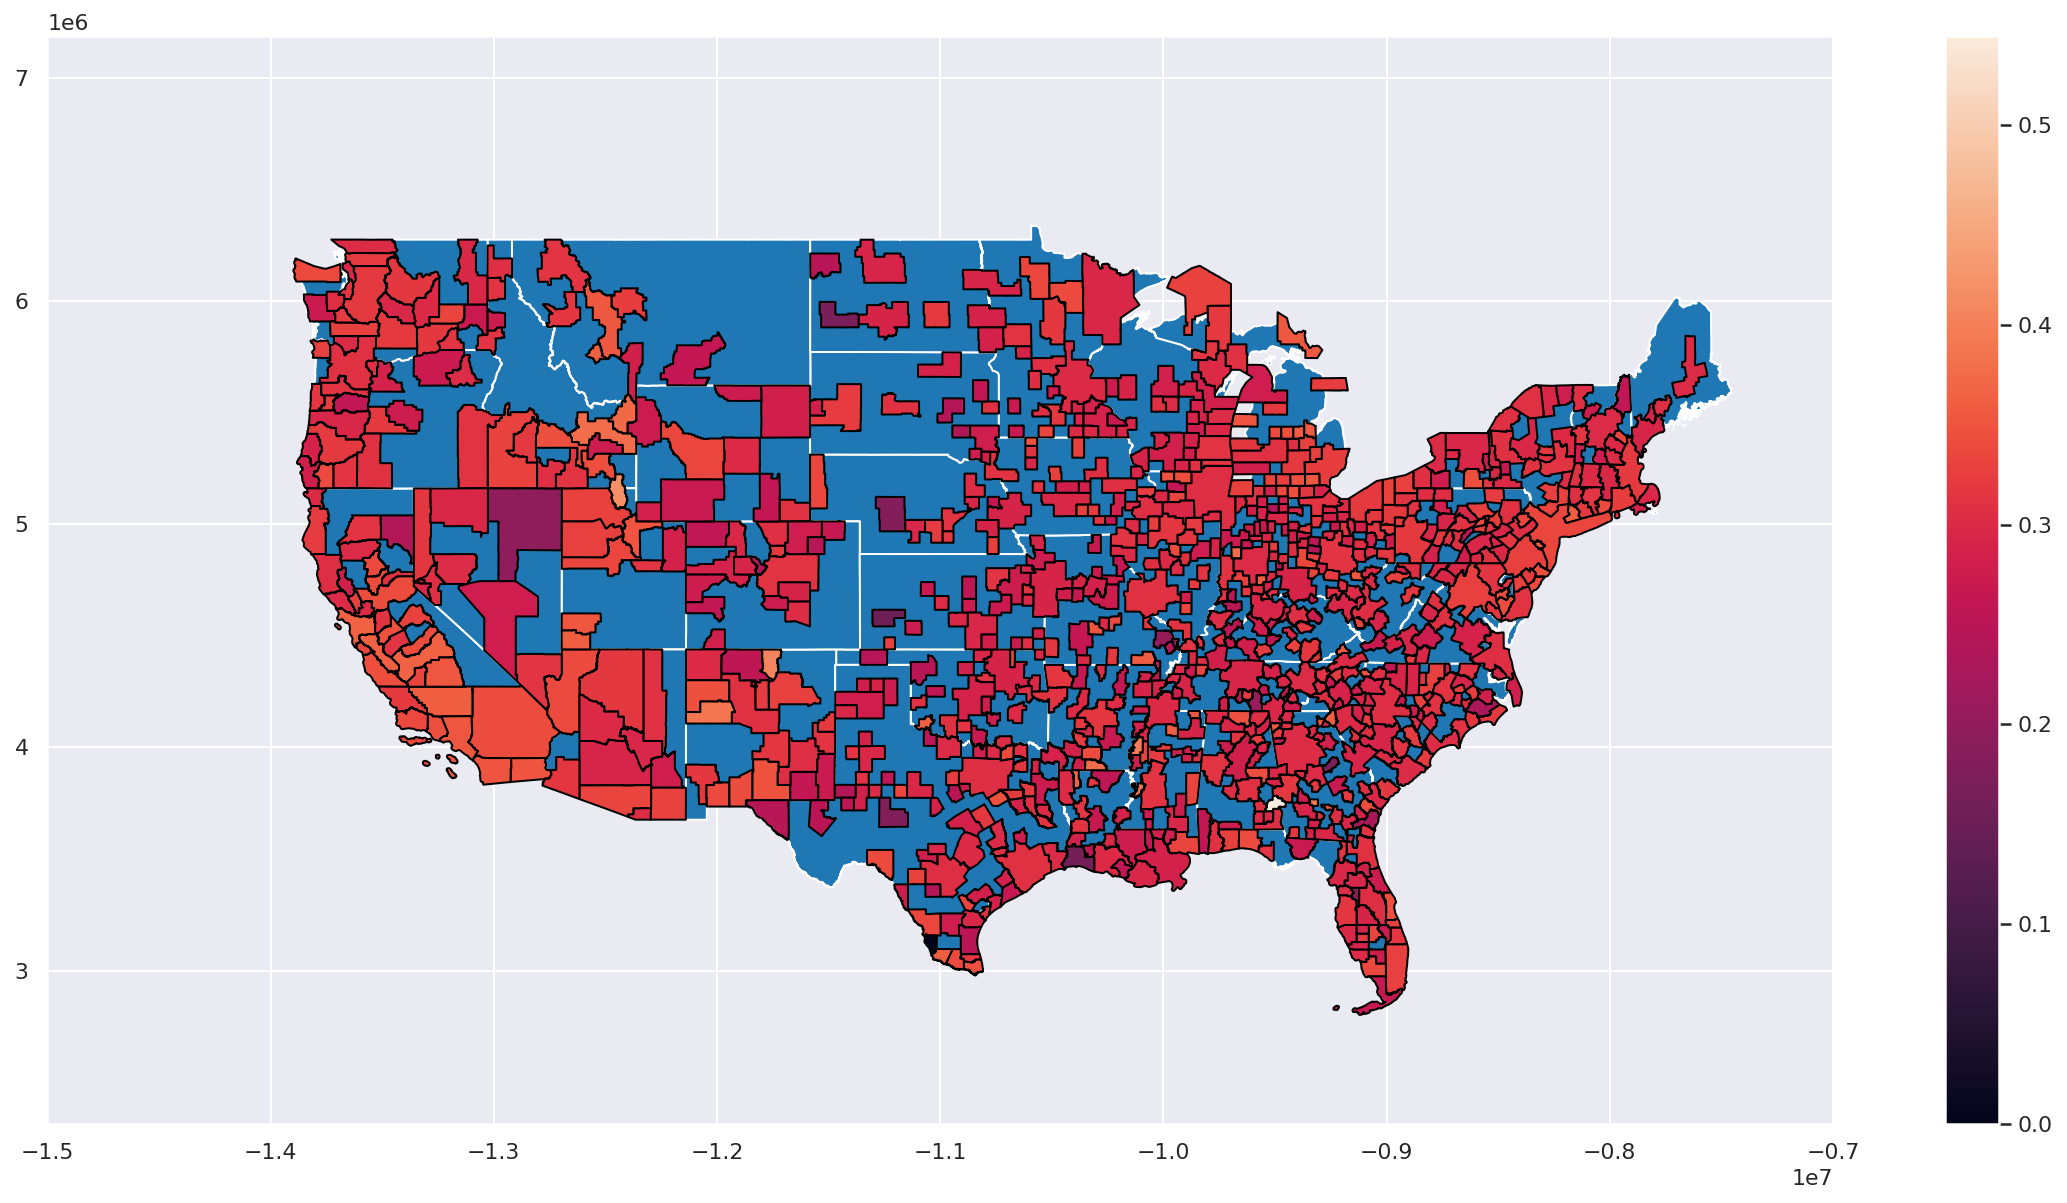

In [119]:
ax = plotUS()
byYear.loc[2020].plot(ax=ax, column='Grad_Prof_pct', edgecolor="black", linewidth=1, legend=True);

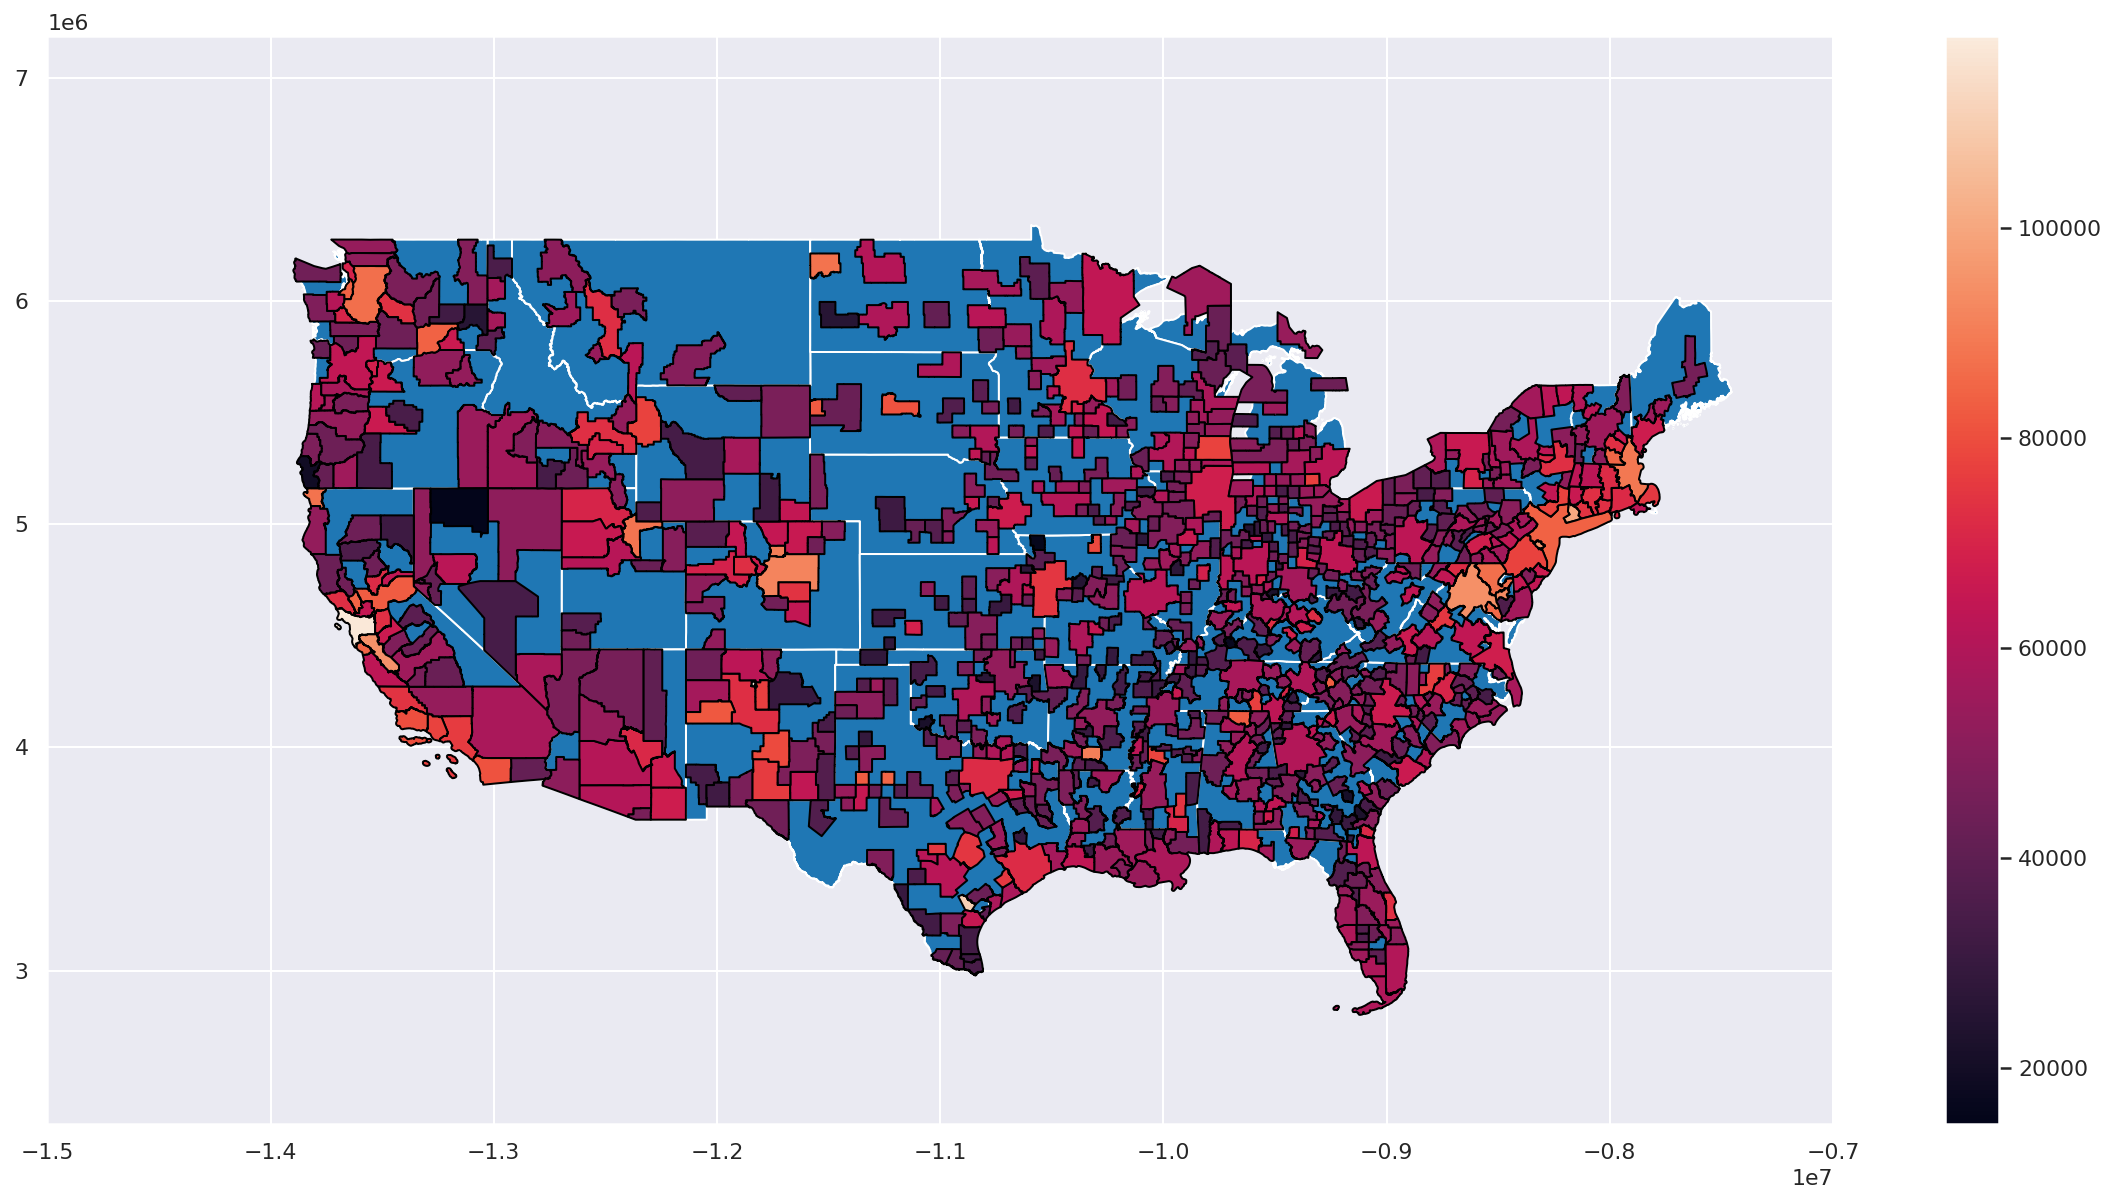

In [120]:
ax = plotUS()
byYear.loc[2021].plot(ax=ax, column='Prof_Sci_Tech', edgecolor="black", linewidth=1, legend=True);

In [121]:
merge['Prof_Sci_Tech'].mean()

43205.89157122281

In [122]:
merge.columns

Index(['CBSA', 'LSAD', 'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022',
       'NAME', 'geometry', 'metro', 'micro', 'buff', 'inBuff',
       'commuteBuffCount_19', 'workingPop_19', 'commutePercent_19',
       'commuteBuffCount_20', 'workingPop_20', 'commutePercent_20', 'liminal',
       'year', 'Total_Population', 'Total_Male_Pop', 'Total_Female_Pop',
       'Median_Age', 'M_Median_Age', 'F_Median_Age', 'Race_white',
       'Race_black', 'Race_Am_Indian', 'Race_Asian', 'Race_Pac_Isl',
       'Median_Income', 'Less_High', 'High_Equiv', 'College_Assoc_Equiv',
       'Bachelors', 'Grad_Prof', 'Med_House_Val', 'Ag_For_Fish_Hunt_Mine',
       'Construction', 'Manufacturing', 'Wholesale', 'Retail',
       'Trans_Ware_Util', 'Information', 'Fin_Insur_Real', 'Fin_Insur',
       'Real_Rental', 'Prof_Sci_Tech', 'Mngmt_Enter', 'Admin_WstMngmt',
       'Ed_Servc', 'Hlthcr_Social', 'Arts_Entr_Rec', 'Accom_Food_Srvc',
       'Other_Servc', 'Public_admin', 'Num_Total_Worker', 'Num_Comp_Info_

In [123]:
#merge = merge[merge['liminal'] == True]

In [124]:
merge[(merge['metro'] == False) & (merge['liminal'] == False)]['Prof_Sci_Tech'].mean()

43507.595960479215

In [125]:
merge[merge['metro']]['Prof_Sci_Tech'].mean()

56861.06984851067

In [126]:
merge[merge['micro']]['Prof_Sci_Tech'].mean()

40000.869004839245

In [127]:
merge[merge['liminal']]['Prof_Sci_Tech'].mean()

39940.95752070531

In [128]:
merge[(merge['metro'] == False) & merge['liminal'] == False]['Sal_Avg_Occ'].mean()

40749.95249409349

In [129]:
merge[merge['metro']]['Avg_Comp_EngSci'].mean()

74875.79277133205

In [130]:
merge[merge['micro']]['Avg_Comp_EngSci'].mean()

59442.613075519715

In [131]:
merge[merge['liminal']]['Avg_Comp_EngSci'].mean()

60234.63188871054

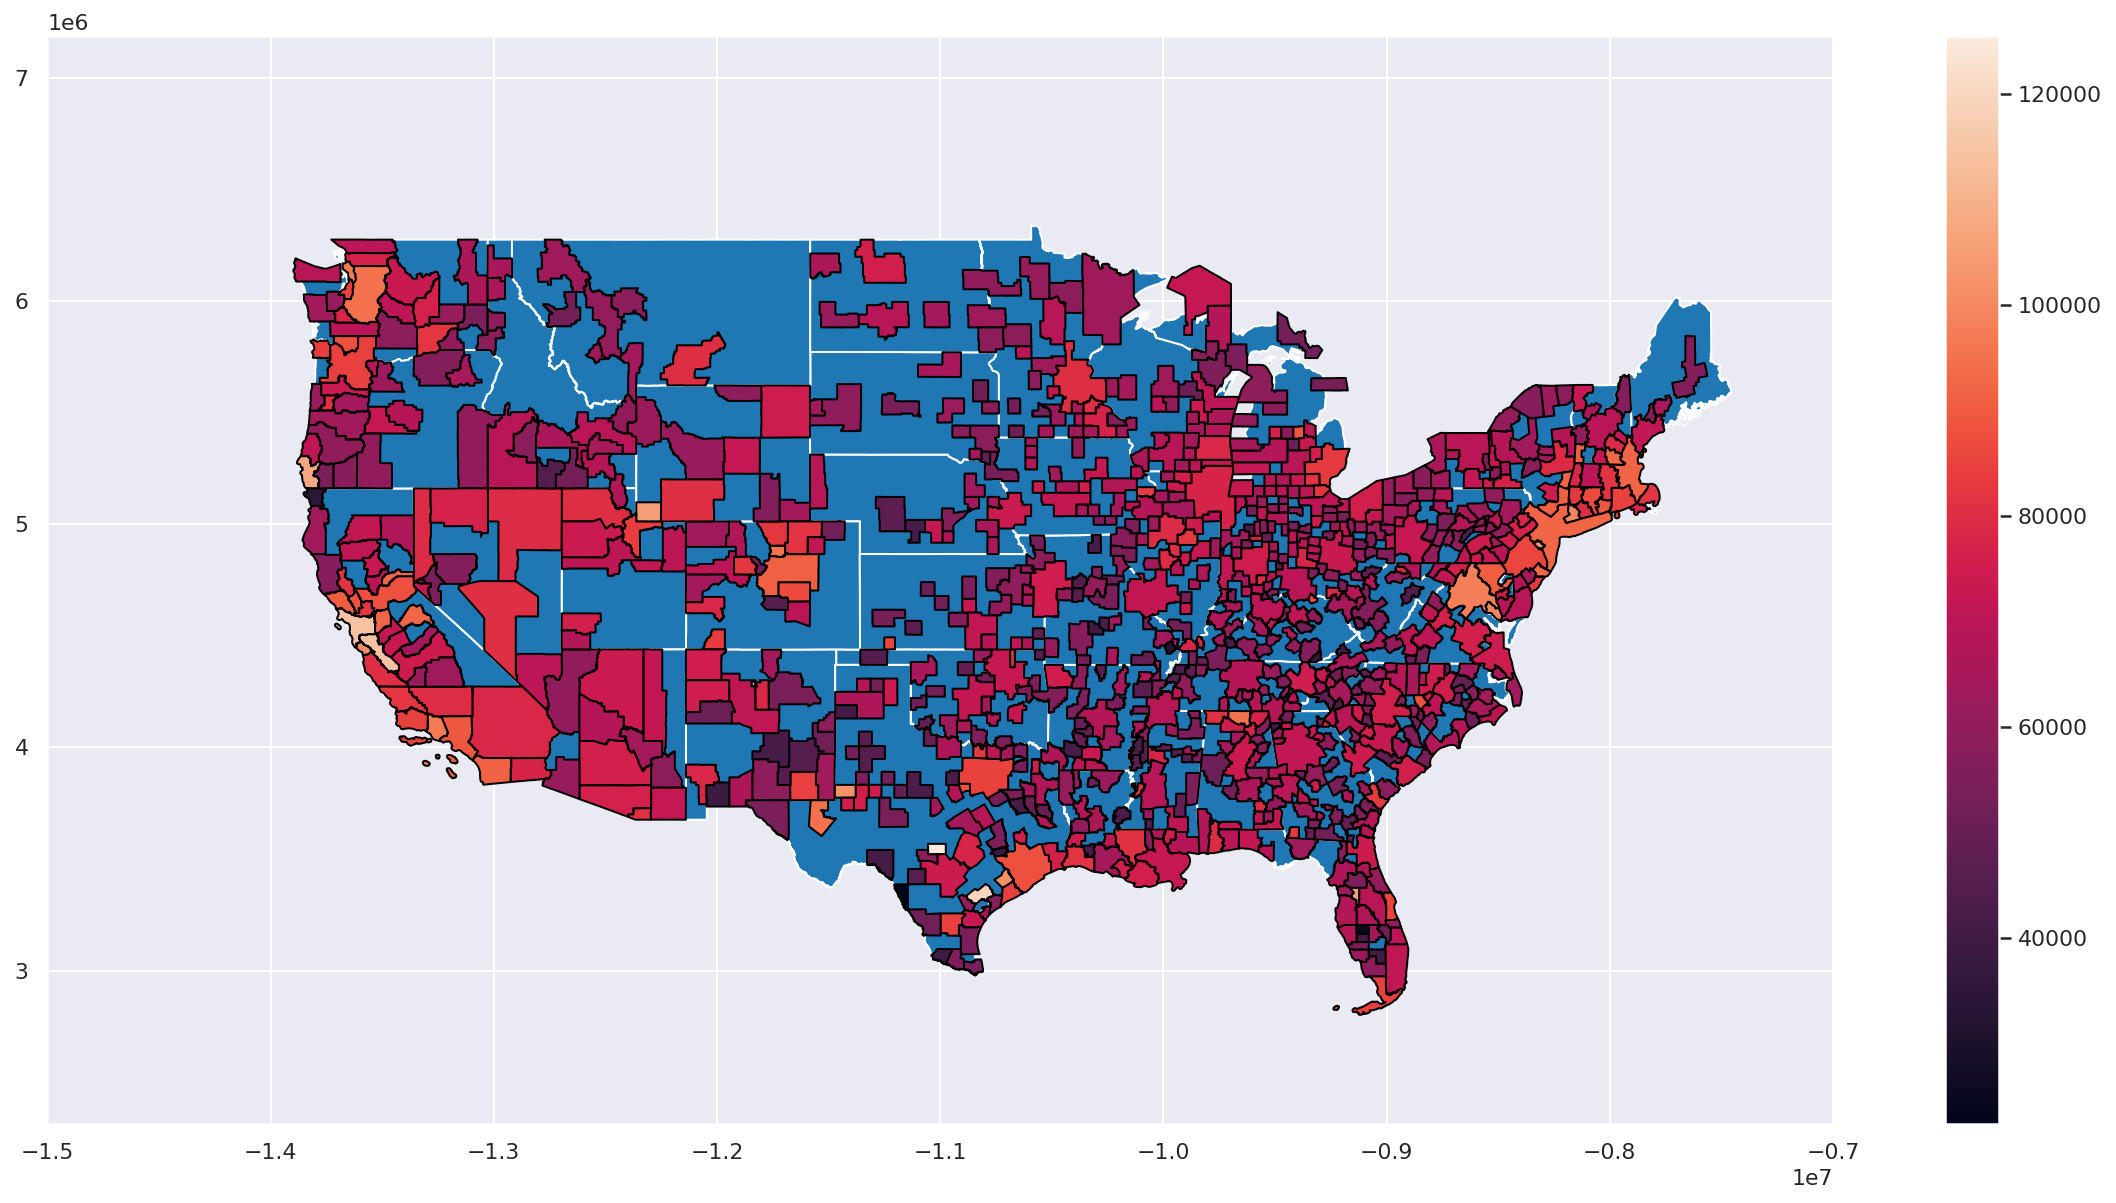

In [132]:
ax = plotUS()
byYear.loc[2018].plot(ax=ax, column='Avg_Comp_EngSci', edgecolor="black", linewidth=1, legend=True);

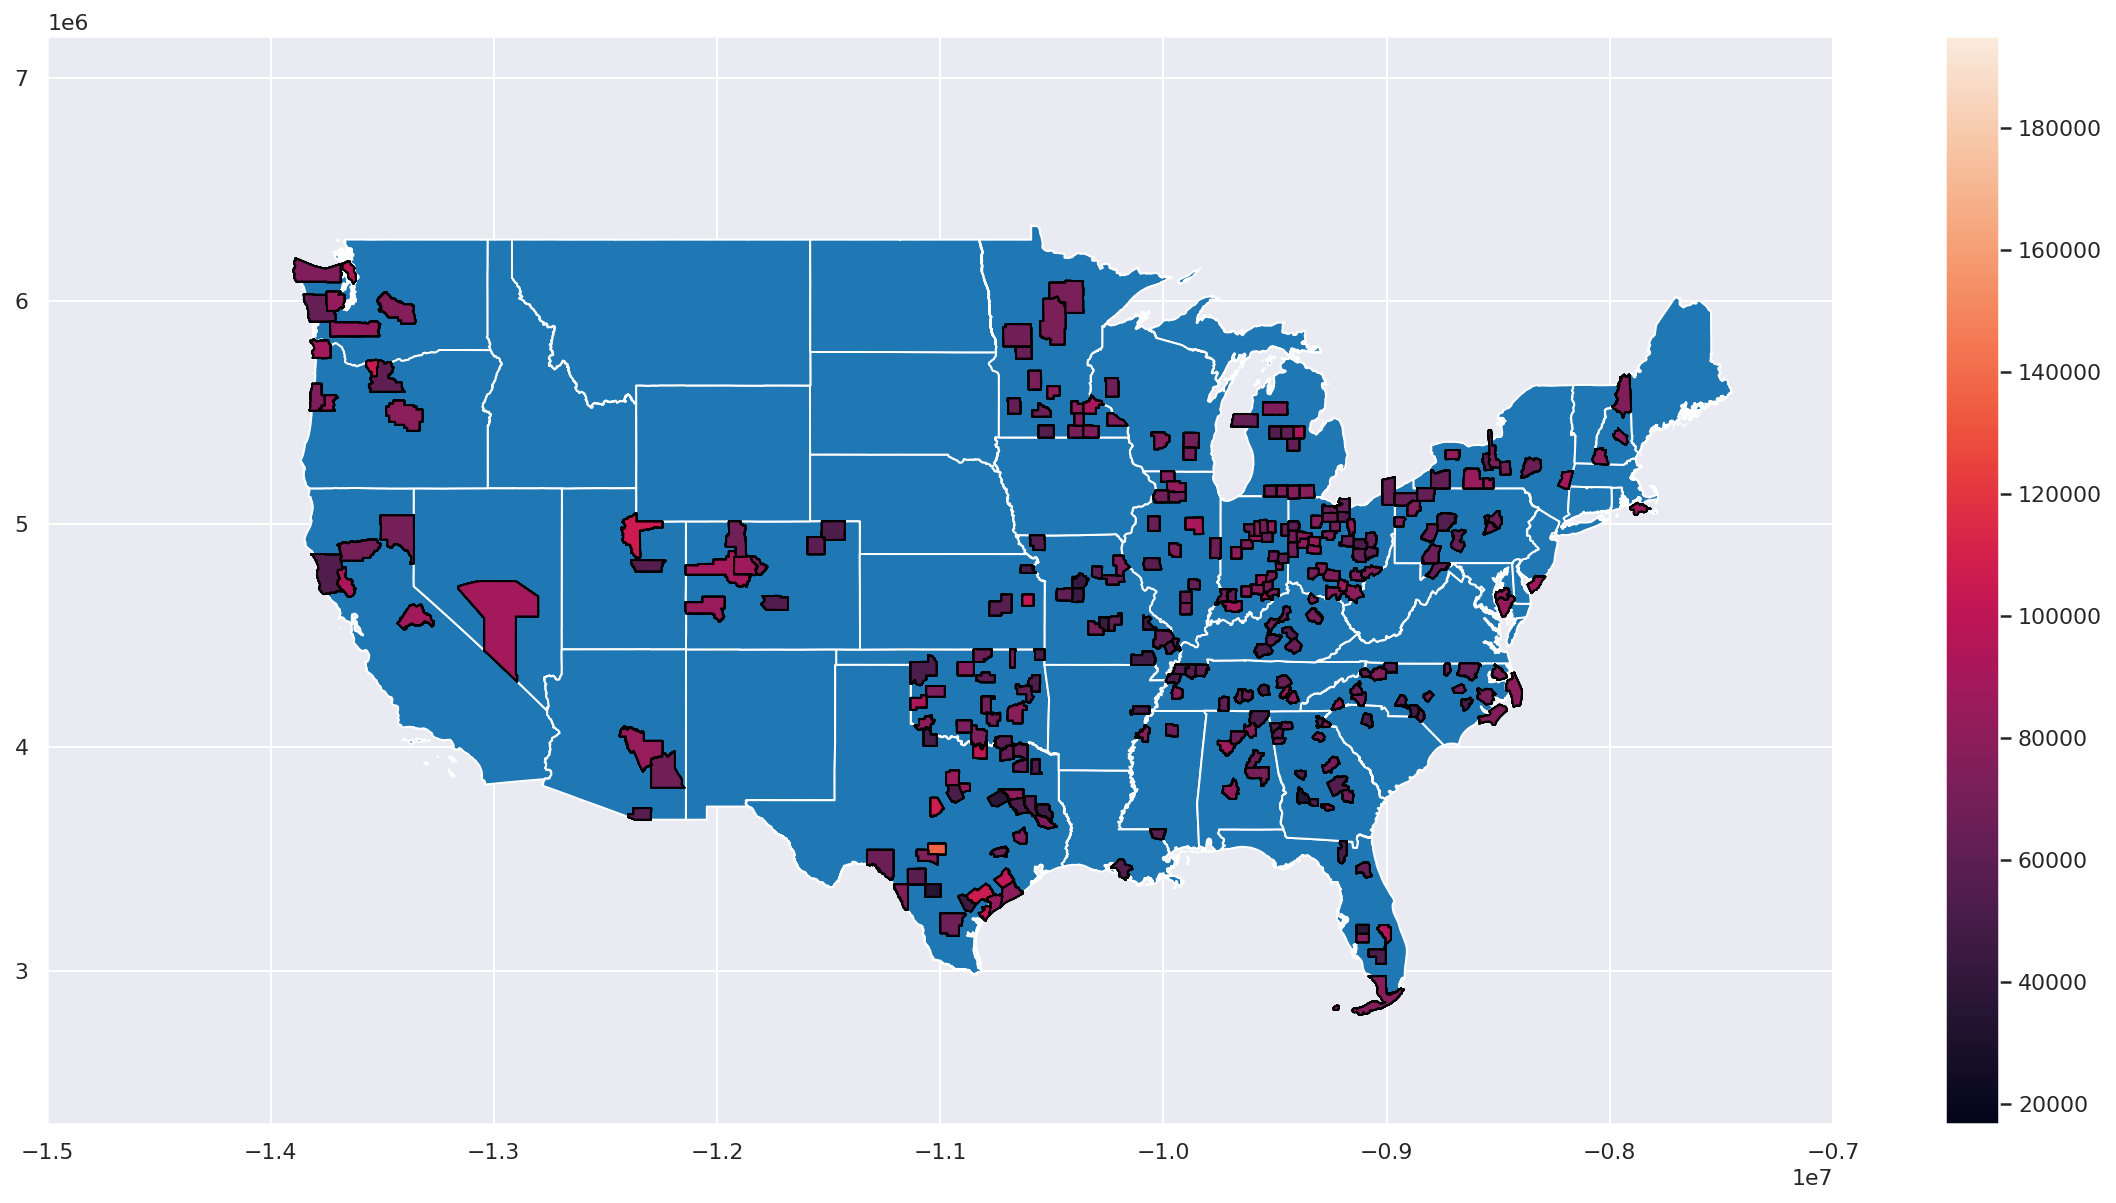

In [133]:
ax = plotUS()
merge[merge['liminal']].plot(ax=ax, column='Avg_Comp_EngSci', edgecolor="black", linewidth=1, legend=True);

In [134]:
merge[(merge['metro'] == False) & (merge['liminal'] == False)]['Avg_Mngmt_Bus_Fin'].mean()

57118.40560318509

In [135]:
merge[merge['metro']]['Avg_Mngmt_Bus_Fin'].mean()

69551.65937390797

In [136]:
merge[merge['micro']]['Avg_Mngmt_Bus_Fin'].mean()

54120.70459547389

In [137]:
merge[merge['liminal']]['Avg_Mngmt_Bus_Fin'].mean()

54358.067752849

In [138]:
for year in years:
    print(merge[(merge['liminal'] == True) & (merge['year'] == year)]['Med_House_Val'].mean())

128590.625
131270.71759259258
131807.63888888888
130043.22916666667
128713.77314814816
127870.48611111111
129486.22685185184
131856.94444444444
136016.26157407404
141204.22453703702
147573.55324074073
155303.00925925927
164586.9212962963


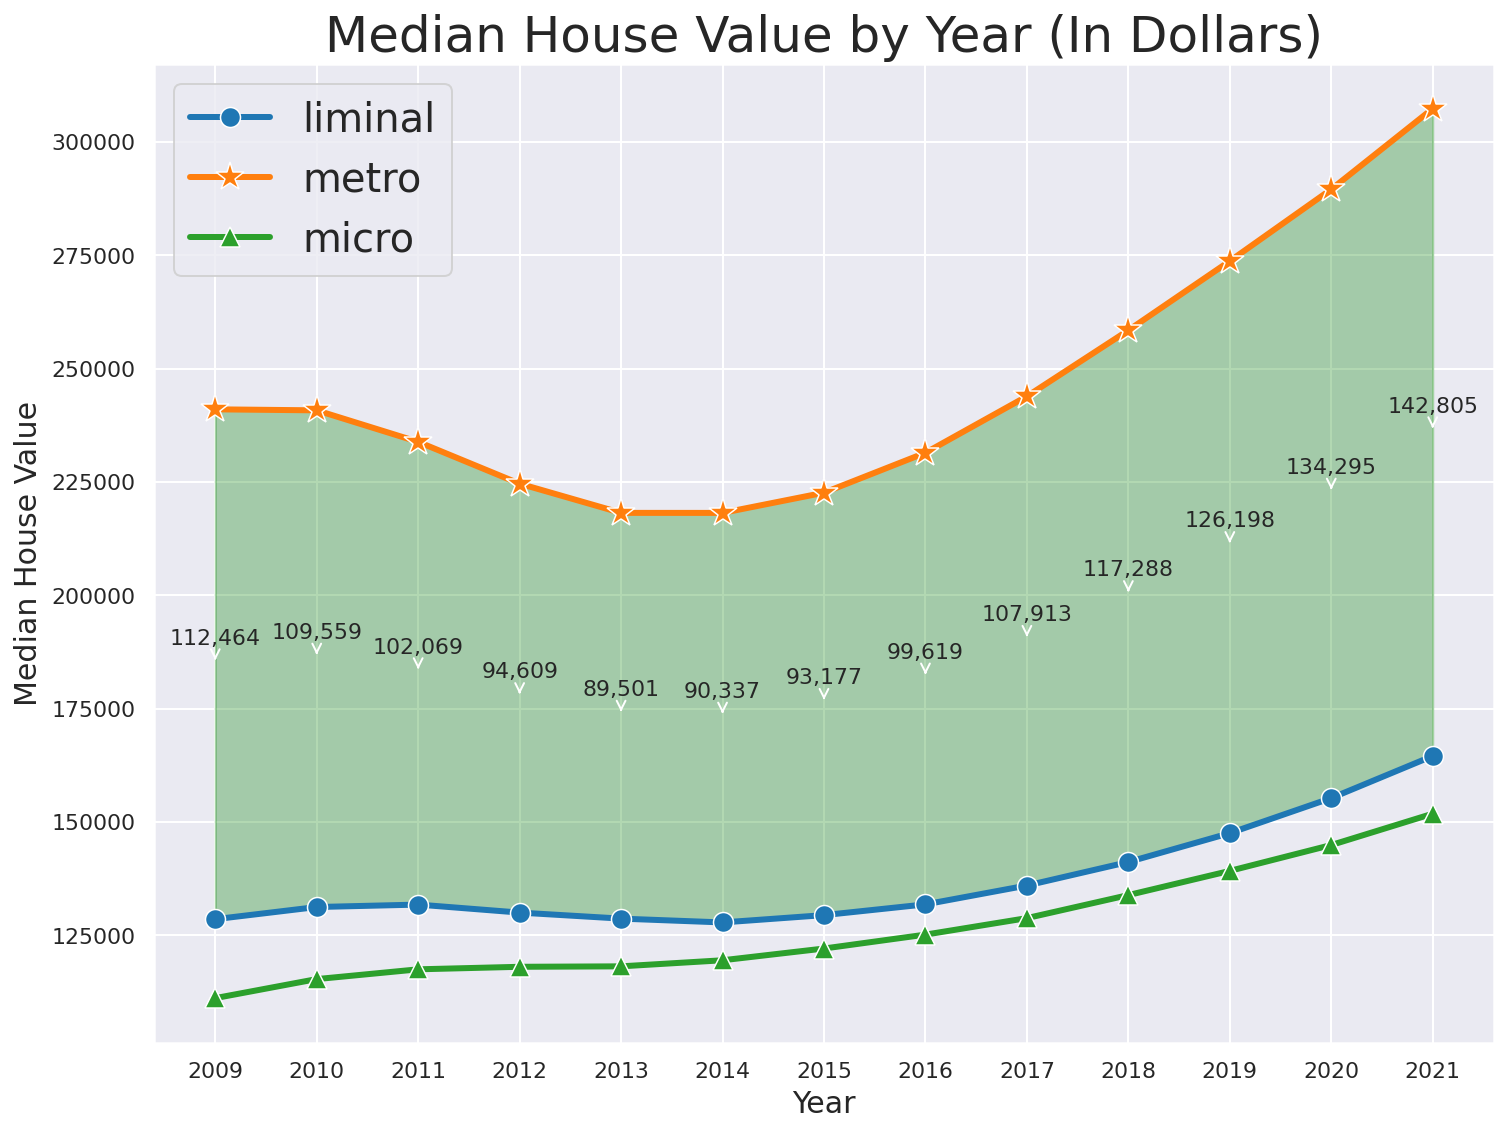

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#Create empty lists to store x and y values for plotting
x_lim_values = []
y_lim_values = []

x_met_values = []
y_met_values = []

x_mic_values = []
y_mic_values = []

for year in years:
    median_val = merge[(merge['liminal'] == True) & (merge['year'] == year)]['Med_House_Val'].mean()
    if not pd.isna(median_val):
        x_lim_values.append(year)
        y_lim_values.append(median_val)

for year in years:
    median_val = merge[(merge['metro'] == True) & (merge['year'] == year)]['Med_House_Val'].mean()
    if not pd.isna(median_val):
        x_met_values.append(year)
        y_met_values.append(median_val)

for year in years:
    median_val = merge[(merge['micro'] == True) & (merge['liminal'] == False) & (merge['year'] == year)]['Med_House_Val'].mean()
    if not pd.isna(median_val):
        x_mic_values.append(year)
        y_mic_values.append(median_val)

sns.set_style('darkgrid')
sns.set_context('notebook')

fig = plt.figure(figsize=(12, 9))

sns.lineplot(x=x_lim_values, y=y_lim_values, marker='o', label='liminal', linewidth = 3, markersize=10)
sns.lineplot(x=x_met_values, y=y_met_values, marker='*', label='metro', linewidth = 3, markersize=15)
sns.lineplot(x=x_mic_values, y=y_mic_values, marker='^', label='micro', linewidth = 3, markersize=10)

#area of difference between metro and liminal values
plt.fill_between(x_lim_values, y_met_values, y_lim_values, where=(np.array(y_met_values) >= np.array(y_lim_values)), interpolate=True, alpha=0.3, color='green')
plt.fill_between(x_lim_values, y_met_values, y_lim_values, where=(np.array(y_met_values) < np.array(y_lim_values)), interpolate=True, alpha=0.3, color='red')

# Add labels for the difference between metro and liminal values with arrows
for i in range(len(x_lim_values)):
    diff = y_met_values[i] - y_lim_values[i]
    xy = (x_lim_values[i], (y_met_values[i] + y_lim_values[i]) / 2)
    xytext = (0, 8) if diff >= 0 else (0, -12)
    va = 'bottom' if diff >= 0 else 'top'
    ha = 'center'
    diff_str = f'{diff:,.0f}'
    plt.annotate(diff_str, xy=xy, xytext=xytext, textcoords='offset points', va=va, ha=ha, fontsize=11, arrowprops=dict(arrowstyle="->"))


plt.legend(fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Median House Value', fontsize=15)
plt.title('Median House Value by Year (In Dollars)', fontsize=25)
plt.grid(True)

# Set x-axis ticks to show all years
plt.xticks(x_lim_values)

plt.show()


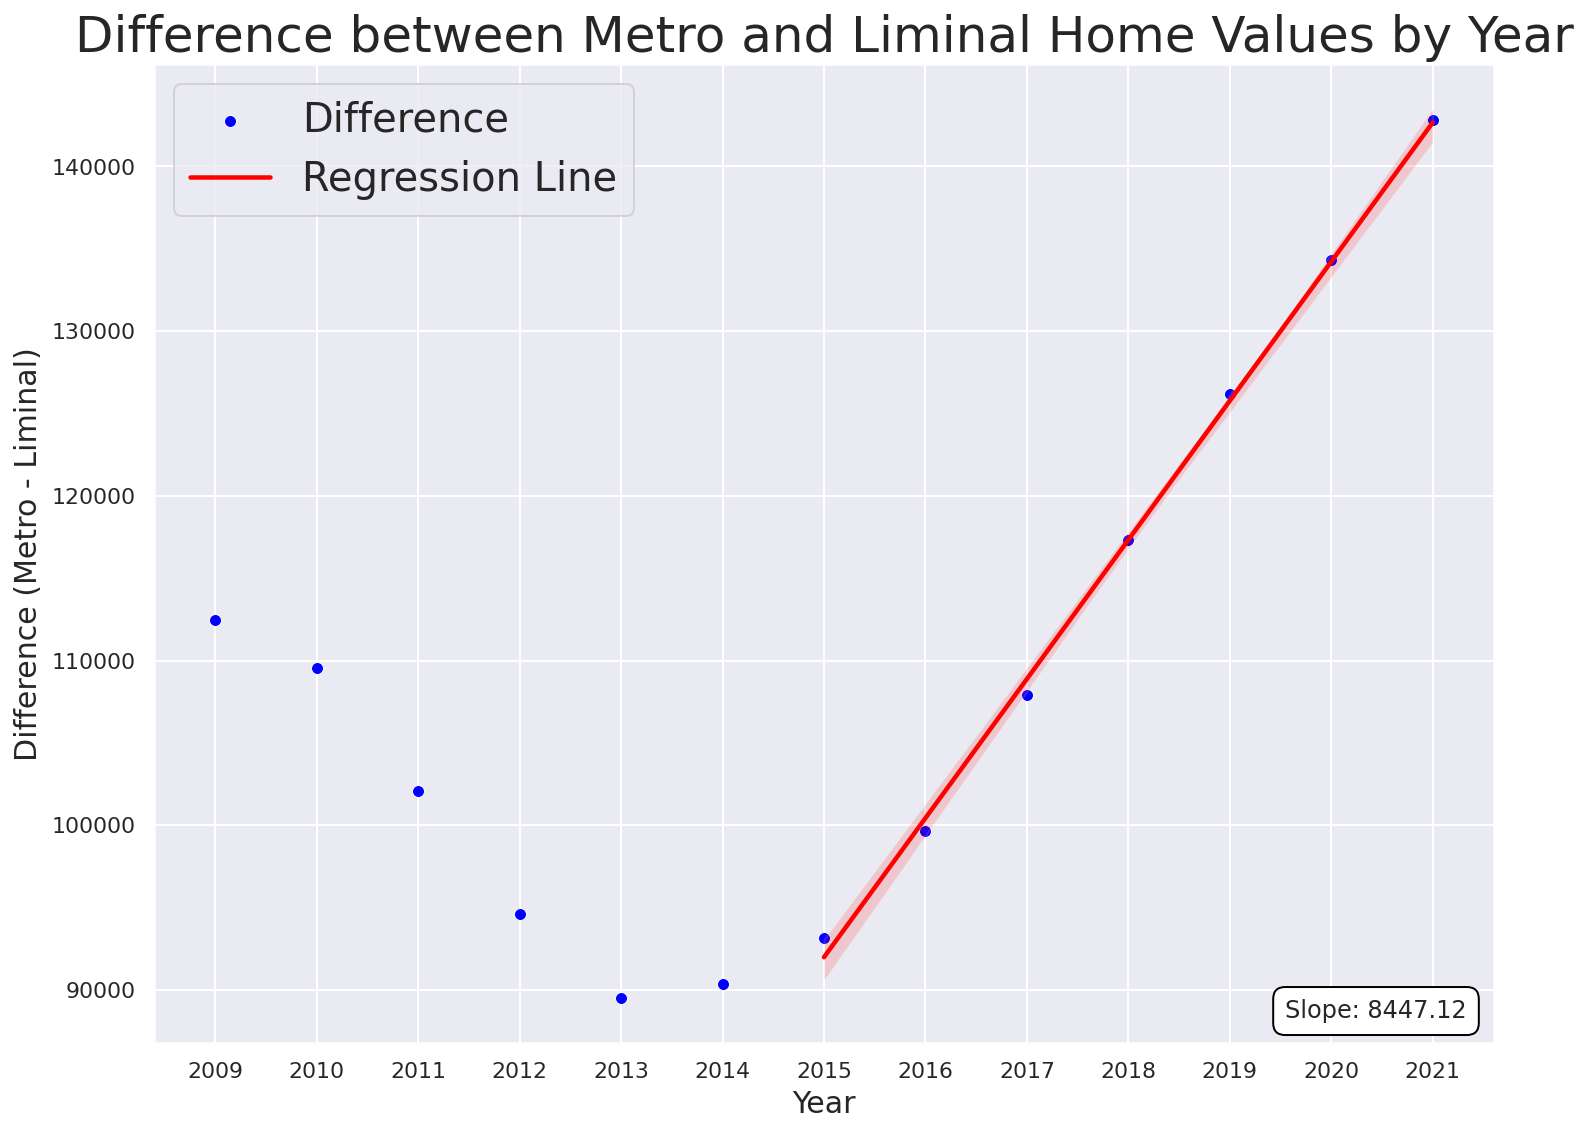

In [140]:
x_diff_values = []
y_diff_values = []

for year in years:
    met_val = merge[(merge['metro'] == True) & (merge['year'] == year)]['Med_House_Val'].mean()
    lim_val = merge[(merge['liminal'] == True) & (merge['year'] == year)]['Med_House_Val'].mean()
    if not pd.isna(met_val) and not pd.isna(lim_val):
        x_diff_values.append(year)
        y_diff_values.append(met_val - lim_val)

sns.set_context('notebook')

fig, ax = plt.subplots(figsize=(12, 9))

#Plotting the difference values
sns.scatterplot(x=x_diff_values, y=y_diff_values, color='blue', label='Difference')

# Regression line for years 2015 to 2021
x_reg_values = x_diff_values[-7:]  # Selecting years 2015 to 2021
y_reg_values = y_diff_values[-7:]  # Corresponding difference values
sns.regplot(x=x_reg_values, y=y_reg_values, scatter=False, color='red', label='Regression Line')

#Calculate regression statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(x_reg_values, y_reg_values)
r_squared = r_value ** 2

# Add regression information at the bottom right of the plot
reg_info = f'Slope: {slope:.2f}'
plt.text(0.98, 0.02, reg_info, transform=ax.transAxes, ha='right', va='bottom', fontsize=12,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.legend(fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Difference (Metro - Liminal)', fontsize=15)
plt.xticks(x_lim_values)
plt.title('Difference between Metro and Liminal Home Values by Year', fontsize=25)
plt.grid(True)

plt.show()


In [141]:
for year in years:
    print(merge[(merge['liminal'] == True) & (merge['year'] == year)]['G_Mobil_Bach_Prof'].mean())

5760.892361111111
5975.739583333333
6087.236111111111
6162.708333333333
6275.621527777777
6420.381944444444
6524.378472222223
6654.274305555556
6844.038194444444
6997.197916666667
7166.604166666667
7437.454861111111
7630.71875


[5760.892361111111, 5975.739583333333, 6087.236111111111, 6162.708333333333, 6275.621527777777, 6420.381944444444, 6524.378472222223, 6654.274305555556, 6844.038194444444, 6997.197916666667, 7166.604166666667, 7437.454861111111, 7630.71875]


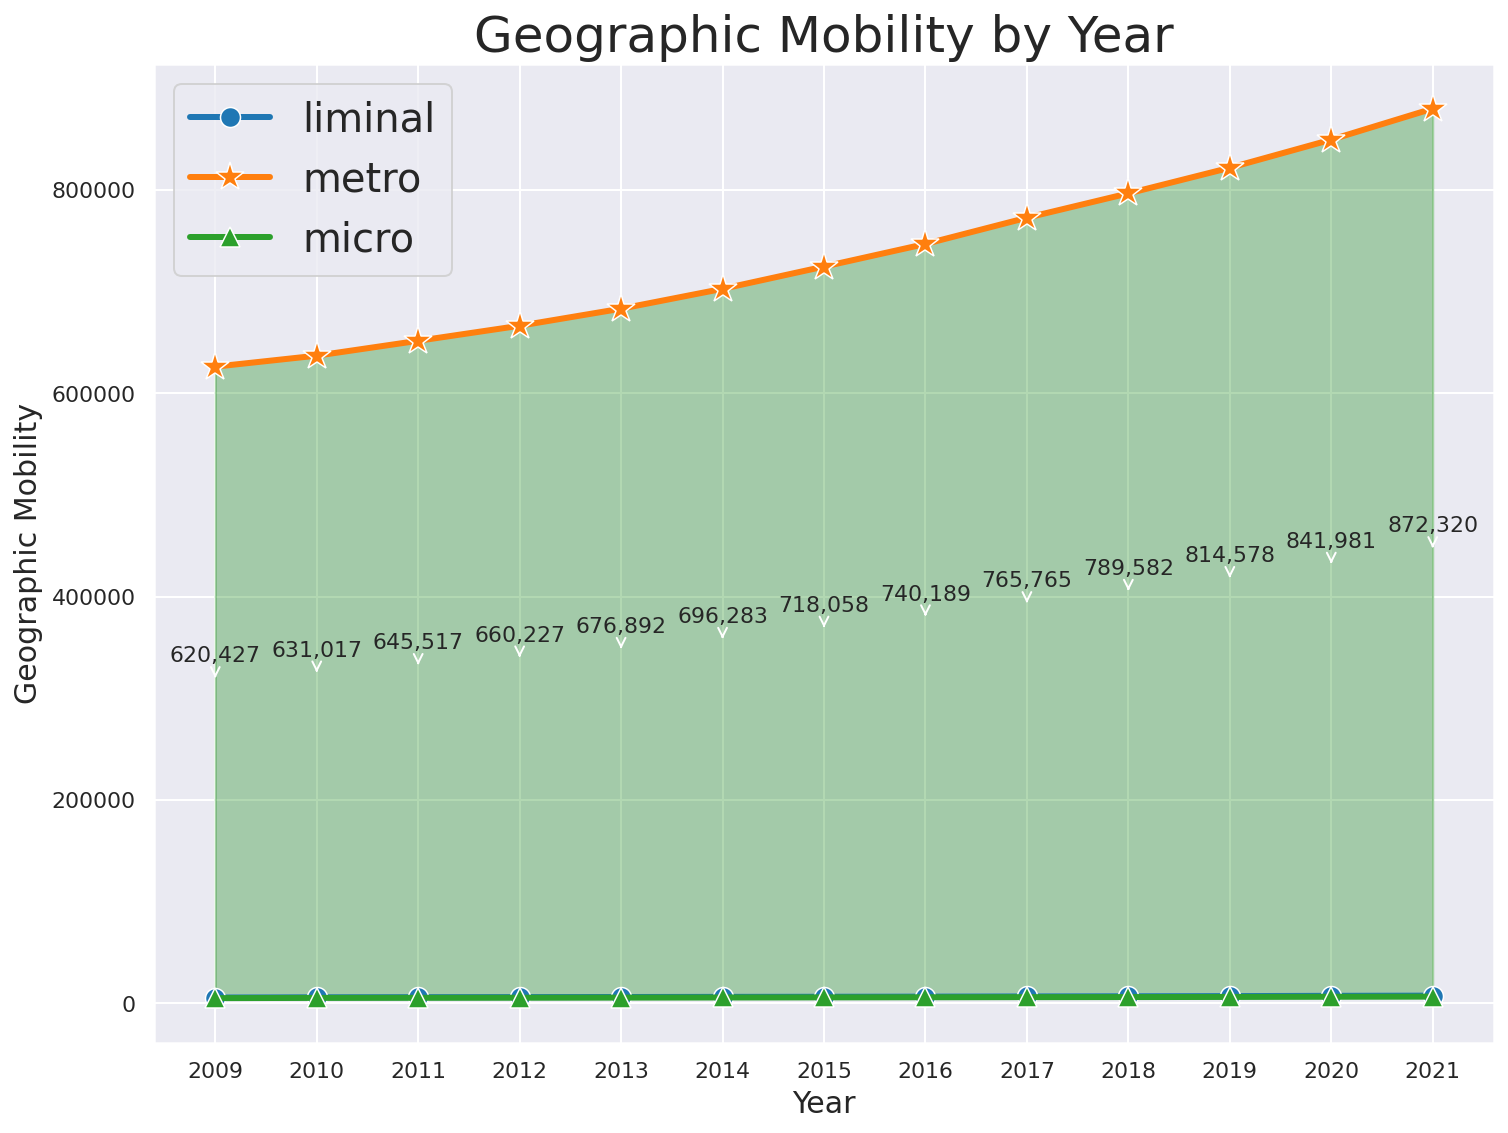

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#Create empty lists to store x and y values for plotting
x_lim_values = []
y_lim_values = []

x_met_values = []
y_met_values = []

x_mic_values = []
y_mic_values = []

for year in years:
    median_val = merge[(merge['liminal'] == True) & (merge['year'] == year)]['G_Mobil_Bach_Prof'].mean()
    if not pd.isna(median_val):
        x_lim_values.append(year)
        y_lim_values.append(median_val)

for year in years:
    median_val = merge[(merge['metro'] == True) & (merge['year'] == year)]['G_Mobil_Bach_Prof'].mean()
    if not pd.isna(median_val):
        x_met_values.append(year)
        y_met_values.append(median_val)

for year in years:
    median_val = merge[(merge['micro'] == True) & (merge['liminal'] == False) & (merge['year'] == year)]['G_Mobil_Bach_Prof'].mean()
    if not pd.isna(median_val):
        x_mic_values.append(year)
        y_mic_values.append(median_val)

sns.set_style('darkgrid')
sns.set_context('notebook')

fig = plt.figure(figsize=(12, 9))

print(y_lim_values)
sns.lineplot(x=x_lim_values, y=y_lim_values, marker='o', label='liminal', linewidth = 3, markersize=10)
sns.lineplot(x=x_met_values, y=y_met_values, marker='*', label='metro', linewidth = 3, markersize=15)
sns.lineplot(x=x_mic_values, y=y_mic_values, marker='^', label='micro', linewidth = 3, markersize=10)

#area of difference between metro and liminal values
plt.fill_between(x_lim_values, y_met_values, y_lim_values, where=(np.array(y_met_values) >= np.array(y_lim_values)), interpolate=True, alpha=0.3, color='green')
plt.fill_between(x_lim_values, y_met_values, y_lim_values, where=(np.array(y_met_values) < np.array(y_lim_values)), interpolate=True, alpha=0.3, color='red')

# Add labels for the difference between metro and liminal values with arrows
for i in range(len(x_lim_values)):
    diff = y_met_values[i] - y_lim_values[i]
    xy = (x_lim_values[i], (y_met_values[i] + y_lim_values[i]) / 2)
    xytext = (0, 8) if diff >= 0 else (0, -12)
    va = 'bottom' if diff >= 0 else 'top'
    ha = 'center'
    diff_str = f'{diff:,.0f}'
    plt.annotate(diff_str, xy=xy, xytext=xytext, textcoords='offset points', va=va, ha=ha, fontsize=11, arrowprops=dict(arrowstyle="->"))


plt.legend(fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Geographic Mobility', fontsize=15)
plt.title('Geographic Mobility by Year', fontsize=25)
plt.grid(True)

# Set x-axis ticks to show all years
plt.xticks(x_lim_values)

plt.show()

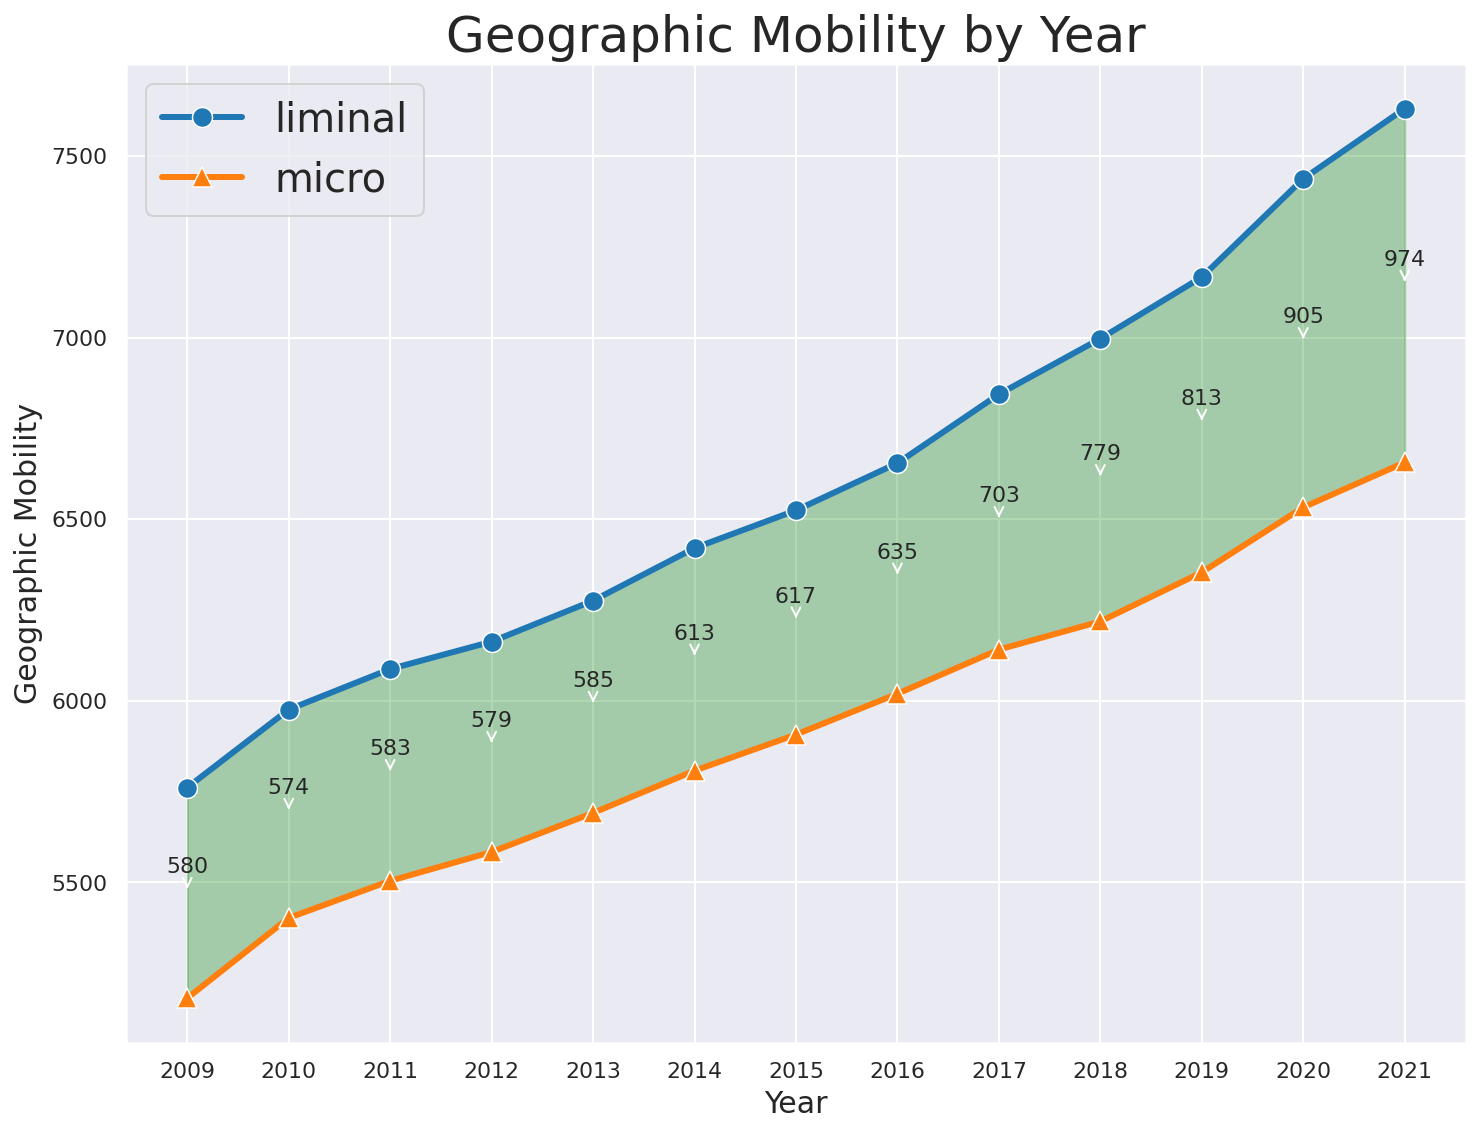

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#Create empty lists to store x and y values for plotting
x_lim_values = []
y_lim_values = []

x_met_values = []
y_met_values = []

x_mic_values = []
y_mic_values = []

for year in years:
    median_val = merge[(merge['liminal'] == True) & (merge['year'] == year)]['G_Mobil_Bach_Prof'].mean()
    if not pd.isna(median_val):
        x_lim_values.append(year)
        y_lim_values.append(median_val)

for year in years:
    median_val = merge[(merge['micro'] == True) & (merge['liminal'] == False) & (merge['year'] == year)]['G_Mobil_Bach_Prof'].mean()
    if not pd.isna(median_val):
        x_mic_values.append(year)
        y_mic_values.append(median_val)

sns.set_style('darkgrid')
sns.set_context('notebook')

fig = plt.figure(figsize=(12, 9))

sns.lineplot(x=x_lim_values, y=y_lim_values, marker='o', label='liminal', linewidth = 3, markersize=10)
sns.lineplot(x=x_mic_values, y=y_mic_values, marker='^', label='micro', linewidth = 3, markersize=10)

#area of difference between metro and liminal values
plt.fill_between(x_mic_values, y_lim_values, y_mic_values, where=(np.array(y_lim_values) >= np.array(y_mic_values)), interpolate=True, alpha=0.3, color='green')
plt.fill_between(x_mic_values, y_lim_values, y_mic_values, where=(np.array(y_lim_values) < np.array(y_mic_values)), interpolate=True, alpha=0.3, color='red')

# Add labels for the difference between metro and liminal values with arrows
for i in range(len(x_mic_values)):
    diff = y_lim_values[i] - y_mic_values[i]
    xy = (x_mic_values[i], (y_lim_values[i] + y_mic_values[i]) / 2)
    xytext = (0, 8) if diff >= 0 else (0, -12)
    va = 'bottom' if diff >= 0 else 'top'
    ha = 'center'
    diff_str = f'{diff:,.0f}'
    plt.annotate(diff_str, xy=xy, xytext=xytext, textcoords='offset points', va=va, ha=ha, fontsize=11, arrowprops=dict(arrowstyle="->"))


plt.legend(fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Geographic Mobility', fontsize=15)
plt.title('Geographic Mobility by Year', fontsize=25)
plt.grid(True)

# Set x-axis ticks to show all years
plt.xticks(x_lim_values)

plt.show()